In [1]:
# !conda install -q -U bitsandbytes
# !conda install -q xformers
# !conda install -q -U git+https://github.com/huggingface/transformers.git
# !conda install -q -U git+https://github.com/huggingface/peft.git
# !conda install -q -U git+https://github.com/huggingface/accelerate.git
# !conda install -q datasets
# !conda install -q einops
# !conda install -q wandb
# !conda install -q scipy

In [2]:
from huggingface_hub import login
login()

In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [4]:
import pandas as pd
from datasets import load_dataset

SQL_SPECIAL_TOKENS = {
    'schema': '<|schema|>',
    'query': '<|query|>',
    'sql': '<|sql|>',
    'endoftext': '<|endoftext|>',
}

def generate_prompt(examples, spider_schemas, use_fields=False):
    """
    Generates the prompt for the given example as follows:
    <|schema|> DATABASE STRUCTURE <|query|> NATURAL LANGUAGE QUESTION <|sql|> SQL QUERY <|endoftext|>

    examples: The example to generate the prompt for.
    spider_schemas: The spider schemas object.
    use_fields: Whether to use the database fields in the prompt.
    """
    prompt = ''

    if use_fields:
      fields = SQL_SPECIAL_TOKENS['schema'] + spider_schemas.get_db_schema(examples['db_id']) + SQL_SPECIAL_TOKENS['endoftext']
      fields.strip()
      prompt += fields

    question = SQL_SPECIAL_TOKENS['query'] + examples['question'] + SQL_SPECIAL_TOKENS['endoftext']
    question.strip()
    prompt += question

    query = SQL_SPECIAL_TOKENS['sql'] + examples['query']
    query.strip()

    if not query.endswith(';'):
        query = query + ';'
    query = query + SQL_SPECIAL_TOKENS['endoftext']

    prompt += query

    return prompt.lower()

def preprocess_function(examples, spider_schema, use_fields=False):
    prompts = generate_prompt(examples, spider_schema, use_fields)
    return {'input_text': prompts}

class SpiderSchema:
    """
    Class to handle the spider dataset schemas.
    """
    def __init__(self, table_json: str):
        self.schema, self.primary, self.foreign = self.get_spider_schemas(table_json)

    def find_db_fields(self, db_name: str):
        """
        Returns the fields of the database with the given name as a string.
        """
        df = self.schema[self.schema['Database name'] == db_name]
        df = df.groupby(' Table Name')
        output = ""
        for name, group in df:
            output += "Table " +name+ ', columns = ['
            for index, row in group.iterrows():
                output += row[" Field Name"]+','
            output = output[:-1]
            output += "]\n"
        return output

    def find_db_primary_keys(self, db_name: str):
        """
        Returns the primary keys of the database with the given name as a string.
        """
        df = self.primary[self.primary['Database name'] == db_name]
        output = "["
        for index, row in df.iterrows():
            output += row['Table Name'] + '.' + row['Primary Key'] +','
        if len(output)>1:
            output = output[:-1]
        output += "]\n"
        return output

    def find_db_foreign_keys(self, db_name: str):
        """
        Returns the foreign keys of the database with the given name as a string.
        """
        df = self.foreign[self.foreign['Database name'] == db_name]
        output = "["
        for index, row in df.iterrows():
            output += row['First Table Name'] + '.' + row['First Table Foreign Key'] + " = " + row['Second Table Name'] + '.' + row['Second Table Foreign Key'] + ','
        output= output[:-1] + "]"
        return output

    def get_db_schema(self, db_name: str) -> str:
        """
        Returns the schema of the database with the given name as a string.
        """
        fields = self.find_db_fields(db_name)
        fields += "Foreign_keys = " + self.find_db_primary_keys(db_name) + '\n'
        fields += "Primary_keys = " + self.find_db_foreign_keys(db_name)
        return fields

    @staticmethod
    def get_spider_schemas(table_json: str):
        """
        Returns the schemas of the spider dataset as pandas dataframes, with the following columns:
        - spider_schema: Database name, Table Name, Field Name, Type
        - spider_primary: Database name, Table Name, Primary Key
        - spider_foreign: Database name, First Table Name, Second Table Name, First Table Foreign Key, Second Table Foreign Key

        :param table_json: path to the table.json file of the spider dataset
        :return: spider_schema, spider_primary, spider_foreign
        """
        schema_df = pd.read_json(table_json)
        schema_df = schema_df.drop(['column_names','table_names'], axis=1)
        schema = []
        f_keys = []
        p_keys = []
        for index, row in schema_df.iterrows():
            tables = row['table_names_original']
            col_names = row['column_names_original']
            col_types = row['column_types']
            foreign_keys = row['foreign_keys']
            primary_keys = row['primary_keys']
            for col, col_type in zip(col_names, col_types):
                index, col_name = col
                if index == -1:
                    for table in tables:
                        schema.append([row['db_id'], table, '*', 'text'])
                else:
                    schema.append([row['db_id'], tables[index], col_name, col_type])
            for primary_key in primary_keys:
                index, column = col_names[primary_key]
                p_keys.append([row['db_id'], tables[index], column])
            for foreign_key in foreign_keys:
                first, second = foreign_key
                first_index, first_column = col_names[first]
                second_index, second_column = col_names[second]
                f_keys.append([row['db_id'], tables[first_index], tables[second_index], first_column, second_column])
        spider_schema = pd.DataFrame(schema, columns=['Database name', ' Table Name', ' Field Name', ' Type'])
        spider_primary = pd.DataFrame(p_keys, columns=['Database name', 'Table Name', 'Primary Key'])
        spider_foreign = pd.DataFrame(f_keys,
                            columns=['Database name', 'First Table Name', 'Second Table Name', 'First Table Foreign Key',
                                    'Second Table Foreign Key'])
        return spider_schema, spider_primary, spider_foreign


def get_dataset(table_json: str, dataset_name: str='spider', use_fields: bool = False):

    dataset = load_dataset(dataset_name)
    spider_schema = SpiderSchema(table_json)
    dataset = dataset.map(
        lambda examples: preprocess_function(examples, spider_schema, use_fields),
        remove_columns=dataset["train"].column_names,
    )
    return dataset

In [5]:
model_id = "tiiuae/falcon-7b"
dataset_id = 'spider'
spider_schema = './tables.json'

In [6]:
dataset = get_dataset(spider_schema, dataset_id, use_fields=True)

Found cached dataset spider (C:/Users/GODZILLA/.cache/huggingface/datasets/spider/spider/1.0.0/4e5143d825a3895451569c8b9b55432b91a4bc2d04d390376c950837f4680daa)


  0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch

class InferenceDataset(Dataset):
    """
    Dataset for inference.

    Arguments:
        dataset: The dataset to use.
        prefix: The prefix to use for the prompt.
    """

    def __init__(self, dataset, prefix = 'Convert text into SQL statements by providing a database schema and a query, and generate the corresponding SQL statement.'):
        self.dataset = dataset
        self.prefix = prefix

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.dataset[idx]

        return self.prefix + sample['input_text'].split('<|sql|>')[0] + '<|sql|>'

In [8]:
eval_batch_size = 1

inference_ds = InferenceDataset(dataset['validation'])
inference_dataloader = DataLoader(inference_ds, batch_size=eval_batch_size, shuffle=False)

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, StoppingCriteriaList, StoppingCriteria
from typing import Optional
from peft import get_peft_model, PeftModel, prepare_model_for_kbit_training

def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return device

def get_model(model_id: str, bnb_config: BitsAndBytesConfig):
    if bnb_config is None:
        model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True)
    else:
        model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0}, trust_remote_code=True)
    return model

def get_tokenizer(model_id: str):
    tokenizer = AutoTokenizer.from_pretrained(model_id, do_lower_case=True)
    return tokenizer

def add_special_tokens_to_tokenizer(tokenizer, SQL_SPECIAL_TOKENS):
    """
    Add special tokens to the tokenizer
    """

    tokenizer.add_special_tokens(
        {
            "pad_token": tokenizer.eos_token,
            "sep_token": tokenizer.eos_token,
        }
    )

    additional_special_tokens = (
        []
        if "additional_special_tokens" not in tokenizer.special_tokens_map
        else tokenizer.special_tokens_map["additional_special_tokens"]
    )

    additional_special_tokens = list(set(additional_special_tokens + list(SQL_SPECIAL_TOKENS.values())))

    num_special_tokens = tokenizer.add_special_tokens({"additional_special_tokens": additional_special_tokens})

    return tokenizer, num_special_tokens

def add_embeddings_to_model(model, tokenizer, SQL_SPECIAL_TOKENS):
    """
    Adds the special tokens embeddings to the model.
    Embeddings are calculated as the mean of the sub-words embeddings.
    """

    # map new tokens
    new_tokens_ids = {}

    for value in SQL_SPECIAL_TOKENS.values():
      ids = tokenizer(value)['input_ids']
      if len(ids) > 1:
        new_tokens_ids[value] = ids

    # retrieve embedding weigths
    embeddings_key = ''
    for k in model.state_dict().keys():
        if 'word_embeddings.weight' in k:
            embeddings_key = k
            break
    embeddings_weights = model.state_dict()[embeddings_key].clone()

    # calculate new tokens embeddings weigths as mean of the sub-words embeddings
    new_tokens_emb_weights = {}

    for token in new_tokens_ids.keys():
      token_emb_list = []
      for ids in new_tokens_ids[token]:
        token_emb = embeddings_weights[ids].clone()
        token_emb_list.append(token_emb)
      token_emb_tensor = torch.stack(token_emb_list)
      # mean of the sub-words embeddings
      mean_emb = torch.mean(token_emb_tensor, dim=0)
      new_tokens_emb_weights[token] = mean_emb

    # add new tokens and special tokens to the tokenizer vocab
    tokenizer, num_special_tokens = add_special_tokens_to_tokenizer(tokenizer, SQL_SPECIAL_TOKENS)

    # resize model embedding
    model.resize_token_embeddings(len(tokenizer))

    vocab_size = tokenizer.vocab_size

    new_embs = model.state_dict()[embeddings_key][
        vocab_size : vocab_size + num_special_tokens, :
    ].clone()

    # add new weights to the model.state_dict
    for token in new_tokens_emb_weights.keys():
      new_ids = tokenizer(token)['input_ids']
      model.state_dict()[embeddings_key][new_ids] = new_tokens_emb_weights[token]

    return new_embs

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

def get_pretrained_model_and_tokenizer(model_id: str, bnb_config: Optional[BitsAndBytesConfig], lora_id: str, add_embeddings: bool = True):
    tokenizer = get_tokenizer(model_id)
    model = get_model(model_id, bnb_config)

    if add_embeddings:
        add_embeddings_to_model(model, tokenizer, SQL_SPECIAL_TOKENS)

    if lora_id:
        model.gradient_checkpointing_enable()
        model = prepare_model_for_kbit_training(model)
        model = PeftModel.from_pretrained(model, lora_id, torch_dtype=torch.bfloat16)

    return model, tokenizer

In [10]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_id = 'gabrielgme/falcon-7b-6ep-spider-with-schema'

model, tokenizer = get_pretrained_model_and_tokenizer(model_id, bnb_config, lora_id)#, lora_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

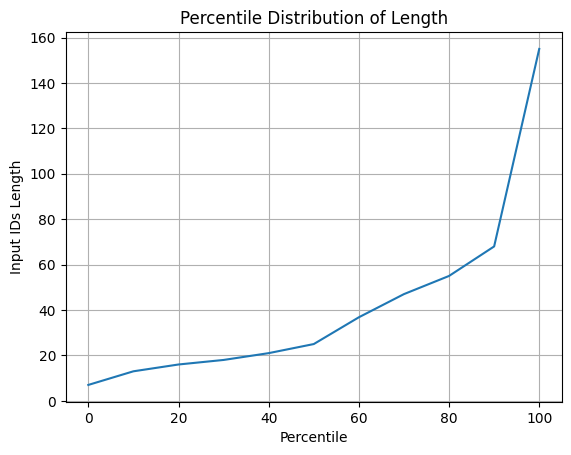

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def preprocess_function(examples):
    return tokenizer(examples['input_text'].split('<|sql|>')[-1])

tokenized_ds = dataset['validation'].map(
    preprocess_function,
    remove_columns=dataset['validation'].column_names,
)

input_ids_lengths = []

for prompt in tokenized_ds:
  input_ids_lengths.append(len(prompt['input_ids']))


percentiles = np.percentile(input_ids_lengths, range(0, 101, 10))

plt.plot(range(0, 101, 10), percentiles)
plt.xlabel("Percentile")
plt.ylabel("Input IDs Length")
plt.title("Percentile Distribution of Length")
plt.grid(True)
plt.show()

In [12]:
import transformers
from tqdm import tqdm

STOP_WORDS = [';', ');', '\';', '";', '<|endoftext|>']

class KeywordsStoppingCriteria(StoppingCriteria):
    def __init__(self, keywords_ids:list):
        self.keywords = keywords_ids

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        if input_ids[0][-1] in self.keywords:
            return True
        return False

def get_stopping_criteria(tokenizer, stop_words=STOP_WORDS):
    stop_ids = [tokenizer.encode(w)[0] for w in stop_words]
    keyword_criteria = KeywordsStoppingCriteria(stop_ids)
    stopping_criteria = StoppingCriteriaList([keyword_criteria])
    return stopping_criteria

def get_pipeline(model, tokenizer):
    pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
        device_map="auto",
    )
    return pipeline

def generate(model, tokenizer, inference_dataloader, max_length=512, max_new_tokens=20, limit_generation=None):
    stopping_criteria = get_stopping_criteria(tokenizer)
    results = []

    generation_config = model.generation_config
    generation_config.max_new_tokens = max_new_tokens
    generation_config.temperature = 0.2
    generation_config.num_return_sequences = 1
    generation_config.pad_token_id = tokenizer.eos_token_id
    generation_config.eos_token_id = tokenizer.eos_token_id
    generation_config.max_length = max_length


    for batch in tqdm(inference_dataloader):
        encoding = tokenizer(batch, return_tensors="pt").to(model.device)
        with torch.inference_mode():
            outputs = model.generate(
                input_ids=encoding["input_ids"],
                attention_mask=encoding["attention_mask"],
                generation_config=generation_config,
                stopping_criteria=stopping_criteria,
                do_sample=False,
                use_cache=True,
            )
        for output in outputs:
            output = tokenizer.decode(output).split('<|sql|>')[-1]
            results.append(output)
        if limit_generation is not None and len(results) >= limit_generation:
            break
    return results

def generate_pipeline(pipeline,
                      inference_dataloader,
                      eos_token_id,
                      pad_token_id,
                      limit_generation=None,
                      max_new_tokens=20,
                      ):
    results = []
    for batch in tqdm(inference_dataloader):
        out = pipeline(batch,
                       do_sample=False,
                       max_new_tokens=max_new_tokens,
                       temperature=0.2,
                       top_k=3,
                       top_p=0.9,
                       repetition_penalty=1.2,
                       num_return_sequences=1,
                       eos_token_id=eos_token_id,
                       pad_token_id=pad_token_id,)
        for res in out:
            prediction = res[0]['generated_text'].split('<|sql|>')[-1]
            print(prediction)
            results.append(prediction)

        if limit_generation is not None and len(results) >= limit_generation:
            break
    return results


In [13]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True

In [14]:
%%time
pipeline = get_pipeline(model, tokenizer)
results = generate_pipeline(pipeline, inference_dataloader, tokenizer.eos_token_id, tokenizer.pad_token_id, max_new_tokens=68) # max new tokens is 160 because the 90th percentile of the input ids length is 160
save_path = './falcon7b6ep.txt'
print('Saving inferences on ', save_path)
with open(save_path, 'w') as f:
    f.write("<separator>".join(results))

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausa

select count(*) from singer;


  0%|          | 2/1034 [00:14<1:57:06,  6.81s/it]

select count(*) from singer;


  0%|          | 3/1034 [00:28<2:55:46, 10.23s/it]

select name,  country,  age from singer order by age desc;


  0%|          | 4/1034 [00:42<3:23:48, 11.87s/it]

select name,  country,  age from singer order by age desc;


  0%|          | 5/1034 [01:08<4:48:33, 16.83s/it]

select avg(age),  min(age),  max(age) from singer where country  =  "france";


  1%|          | 6/1034 [01:35<5:47:06, 20.26s/it]

select avg(age),  min(age),  max(age) from singer where country  =  "france";


  1%|          | 7/1034 [02:33<9:19:46, 32.70s/it]

select t2.song_name,  t2.song_release_year from singer_in_concert as t1 join singer as t2 on t1.singer_id  =  t2.singer_id order by t1.singer_id asc limit 1;


  1%|          | 8/1034 [02:53<8:09:50, 28.65s/it]

select song_name,  song_release_year from singer order by age limit 1;


  1%|          | 9/1034 [03:08<6:54:13, 24.25s/it]

select country from singer where age  >  20 group by country;


  1%|          | 10/1034 [03:20<5:48:51, 20.44s/it]

select country from singer where age  >  20;


/home/CIN/gme/TCC/base/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  1%|          | 11/1034 [03:33<5:09:04, 18.13s/it]

select country,  count(*) from singer group by country;


  1%|          | 12/1034 [03:45<4:41:38, 16.53s/it]

select country,  count(*) from singer group by country;


  1%|▏         | 13/1034 [04:05<4:57:11, 17.46s/it]

select song_name from singer where age  >  (select avg(age) from singer);


  1%|▏         | 14/1034 [04:25<5:08:30, 18.15s/it]

select song_name from singer where age  >  (select avg(age) from singer);


  1%|▏         | 15/1034 [04:44<5:11:49, 18.36s/it]

select location,  name from stadium where capacity between 5000 and 10000;


  2%|▏         | 16/1034 [05:03<5:14:19, 18.53s/it]

select location,  name from stadium where capacity between 5000 and 10000;


  2%|▏         | 17/1034 [05:18<4:56:40, 17.50s/it]

select max(capacity),  avg(capacity) from stadium;


  2%|▏         | 18/1034 [05:33<4:44:14, 16.79s/it]

select avg(capacity),  max(capacity) from stadium;


  2%|▏         | 19/1034 [06:37<8:46:45, 31.14s/it]

select t2.name,  t2.capacity from stadium as t1 join stadium_in_concert as t2 on t1.stadium_id  =  t2.stadium_id group by t1.stadium_id order by avg(t1.capacity) desc limit 1;


  2%|▏         | 20/1034 [07:42<11:36:09, 41.19s/it]

select t2.name,  t2.capacity from stadium as t1 join stadium_in_concert as t2 on t1.stadium_id  =  t2.stadium_id group by t1.stadium_id order by avg(t1.capacity) desc limit 1;


  2%|▏         | 21/1034 [08:04<9:56:24, 35.32s/it] 

select count(*) from concert where year  =  2014 or year  =  2015;


  2%|▏         | 22/1034 [08:25<8:46:28, 31.21s/it]

select count(*) from concert where year  =  2014 or year  =  2015;


  2%|▏         | 23/1034 [09:15<10:21:17, 36.87s/it]

select t2.name,  count(*) from stadium as t1 join singer_in_concert as t2 on t1.stadium_id  =  t2.stadium_id group by t1.stadium_id;


  2%|▏         | 24/1034 [09:28<8:16:16, 29.48s/it] 

select stadium_id from stadium group by stadium_id;


  2%|▏         | 25/1034 [10:18<10:00:37, 35.72s/it]

select t2.name,  t1.capacity from stadium as t1 join concert as t2 on t1.stadium_id  =  t2.stadium_id where t2.year  >  2014;


  3%|▎         | 26/1034 [11:23<12:26:00, 44.41s/it]

select t2.name,  t2.capacity from stadium as t1 join singer_in_concert as t2 on t1.stadium_id  =  t2.stadium_id where t1.year  >  2013 group by t1.stadium_id order by count(*)


  3%|▎         | 27/1034 [11:39<10:02:18, 35.89s/it]

select year from concert group by year order by count(*) desc limit 1;


  3%|▎         | 28/1034 [11:51<8:02:40, 28.79s/it] 

select year from concert order by year desc limit 1;


  3%|▎         | 29/1034 [12:28<8:47:05, 31.47s/it]

select distinct t2.name from stadium as t1 join stadium_in_concert as t2 on t1.stadium_id  =  t2.stadium_id;


  3%|▎         | 30/1034 [12:47<7:43:18, 27.69s/it]

select name from stadium where stadium_id not in (select stadium_id from concert);


  3%|▎         | 31/1034 [13:11<7:22:40, 26.48s/it]

select country from singer where age  >  40 intersect select country from singer where age  <  30;


  3%|▎         | 32/1034 [13:37<7:22:12, 26.48s/it]

select name from stadium where stadium_id not in (select stadium_id from concert where year  =  2014);


  3%|▎         | 33/1034 [13:51<6:15:26, 22.50s/it]

select name from stadium where year !=   2014;


  3%|▎         | 34/1034 [14:47<9:02:39, 32.56s/it]

select t1.concert_name,  t1.theme,  count(*) from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id group by t1.concert_id;


  3%|▎         | 35/1034 [15:43<10:59:15, 39.60s/it]

select t1.concert_name,  t2.theme,  count(*) from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id group by t1.concert_name;


  3%|▎         | 36/1034 [16:30<11:37:19, 41.92s/it]

select t1.name,  count(*) from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id group by t1.name;


  4%|▎         | 37/1034 [17:20<12:18:10, 44.42s/it]

select t1.name,  count(*) from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id group by t1.singer_id;


  4%|▎         | 38/1034 [17:34<9:42:01, 35.06s/it] 

select name from concert where year  =  2014;


  4%|▍         | 39/1034 [18:19<10:33:14, 38.19s/it]

select t2.name from concert as t1 join singer_in_concert as t2 on t1.concert_id  =  t2.concert_id where t1.year  =  2014;


  4%|▍         | 40/1034 [19:14<11:57:06, 43.29s/it]

select t1.name,  t1.country from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id where t2.song_name like '%hey%';


  4%|▍         | 41/1034 [20:09<12:55:40, 46.87s/it]

select t1.name,  t1.country from singer as t1 join singer_in_concert as t2 on t1.singer_id  =  t2.singer_id where t2.song_title like '%hey%';


  4%|▍         | 42/1034 [21:14<14:23:43, 52.24s/it]

select t1.name,  t1.location from stadium as t1 join concert as t2 on t1.stadium_id  =  t2.stadium_id where t2.year  =  2014 intersect select t1.name,  t1.location from stadium as t


  4%|▍         | 43/1034 [22:19<15:25:00, 56.00s/it]

select t2.name,  t2.location from stadium as t1 join stadium_in_concert as t2 on t1.stadium_id  =  t2.stadium_id where t1.year  =  2014 intersect select t2.name,  t2.location


  4%|▍         | 44/1034 [23:24<16:06:56, 58.60s/it]

select count(*) from stadium as t1 join singer_in_concert as t2 on t1.stadium_id  =  t2.stadium_id join concert as t3 on t2.concert_id  =  t3.concert_id where t3.highest  =  t1.capacity


  4%|▍         | 45/1034 [24:28<16:36:06, 60.43s/it]

select count(*) from stadium as t1 join singer_in_concert as t2 on t1.stadium_id  =  t2.stadium_id join concert as t3 on t2.concert_id  =  t3.concert_id where t3.capacity  = ( select max(


  4%|▍         | 46/1034 [24:41<12:40:30, 46.19s/it]

select count(*) from pets where weight  >  10;


  5%|▍         | 47/1034 [24:54<9:55:00, 36.17s/it] 

select count(*) from pets where weight  >  10;


  5%|▍         | 48/1034 [25:10<8:12:47, 29.99s/it]

select pet_age from pets order by pet_age desc limit 1;


  5%|▍         | 49/1034 [25:23<6:52:04, 25.10s/it]

select weight from pets where pet_age  =   1;


  5%|▍         | 50/1034 [26:10<8:36:53, 31.52s/it]

select max(weight),  t1.pet_type from pets as t1 join has_pet as t2 on t1.petid  =  t2.petid group by t2.pet_type;


  5%|▍         | 51/1034 [26:28<7:32:02, 27.59s/it]

select max(weight),  pet_type from pets group by pet_type;


  5%|▌         | 52/1034 [27:06<8:22:42, 30.72s/it]

select count(*) from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid where t2.age  >  20;


  5%|▌         | 53/1034 [27:44<8:58:34, 32.94s/it]

select count(*) from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid where t2.age  >  20;


  5%|▌         | 54/1034 [28:09<8:15:00, 30.31s/it]

select count(*) from has_pet where pet_type  =  "dog" and sex  =  "f";


  5%|▌         | 55/1034 [28:33<7:43:43, 28.42s/it]

select count(*) from has_pet where pet_type  =  "dog" and sex  =  "female";


  5%|▌         | 56/1034 [28:45<6:22:38, 23.48s/it]

select count(distinct pet_type) from pets;


  6%|▌         | 57/1034 [28:57<5:30:40, 20.31s/it]

select count(distinct pettype) from has_pet;


  6%|▌         | 58/1034 [29:22<5:48:51, 21.45s/it]

select fname from student where pet_type  =  "cat" or pet_type  =  "dog";


  6%|▌         | 59/1034 [30:26<9:15:35, 34.19s/it]

select t1.fname from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid where t2.pet_type  =  "cat" intersect select t1.fname from has_pet as t1 join student as t2 on t1.


  6%|▌         | 60/1034 [31:29<11:39:49, 43.11s/it]

select t1.fname from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid where t2.petid in (select petid from pets where pet_type  =  'cat' intersect select petid from pets where pet_type  =


  6%|▌         | 61/1034 [32:33<13:20:33, 49.37s/it]

select t1.fname from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid where t2.petid in (select petid from pets where pet_type  =  "cat" intersect select petid from pets where pet_type  =


  6%|▌         | 62/1034 [33:21<13:11:55, 48.88s/it]

select t2.major,  t2.age from student as t1 join has_pet as t2 on t1.stuid  =  t2.petid where t1.petid  =  'cat';


  6%|▌         | 63/1034 [34:08<13:02:02, 48.32s/it]

select t1.major from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid where t2.petid  =  -1 group by t1.major;


  6%|▌         | 64/1034 [34:57<13:02:23, 48.40s/it]

select stuid from has_pet except select t1.stuid from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid where t2.major  =  "cat";


  6%|▋         | 65/1034 [35:56<13:54:03, 51.64s/it]

select stuid from has_pet except select t1.stuid from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid where t2.sex  = 'm' and t2.major  =  'cs';


  6%|▋         | 66/1034 [36:28<12:17:06, 45.69s/it]

select fname,  age from student where stuid in ( select stuid from has_pet where petid !=  "cat" );


  6%|▋         | 67/1034 [37:32<13:44:47, 51.18s/it]

select t1.fname from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid where t2.petid  =  'dog' except select t1.fname from student as t1 join has_pet as t2 on t1.st


  7%|▋         | 68/1034 [37:51<11:10:33, 41.65s/it]

select pet_type,  weight from pets order by pet_age desc limit 1;


  7%|▋         | 69/1034 [38:10<9:18:30, 34.73s/it] 

select pettype,  weight from pets order by pet_age desc limit 1;


  7%|▋         | 70/1034 [38:29<8:04:40, 30.17s/it]

select pet_id,  weight from pets where pet_age  >  1;


  7%|▋         | 71/1034 [38:48<7:08:18, 26.69s/it]

select petid,  weight from pets where pet_age  >  1;


  7%|▋         | 72/1034 [39:07<6:33:04, 24.52s/it]

select avg(age),  max(age) from pets group by pet_type;


  7%|▋         | 73/1034 [39:27<6:08:09, 22.99s/it]

select avg(age),  max(age) from pets group by pet_type;


  7%|▋         | 74/1034 [39:47<5:55:12, 22.20s/it]

select avg(weight),  pet_type from has_pet group by pet_type;


  7%|▋         | 75/1034 [40:07<5:45:38, 21.62s/it]

select avg(weight),  pet_type from has_pet group by pet_type;


  7%|▋         | 76/1034 [40:30<5:48:29, 21.83s/it]

select fname,  age from student where stuid in (select stuid from has_pet);


  7%|▋         | 77/1034 [41:15<7:38:40, 28.76s/it]

select t1.fname,  t1.age from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid group by t1.fname;


  8%|▊         | 78/1034 [41:57<8:41:17, 32.72s/it]

select t1.petid from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid where t2.lname  = 'smith';


  8%|▊         | 79/1034 [42:39<9:25:55, 35.56s/it]

select t1.petid from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid where t2.lname  = 'smith';


  8%|▊         | 80/1034 [43:08<8:57:36, 33.81s/it]

select count(*),  stuid from has_pet group by stuid having count(*)  >  1 intersect select stuid from student;


  8%|▊         | 81/1034 [43:25<7:35:32, 28.68s/it]

select stuid,  count(*) from has_pet group by stuid;


  8%|▊         | 82/1034 [44:07<8:38:17, 32.67s/it]

select fname,  lname,  age,  sex from student where stuid in ( select stuid from has_pet group by stuid having count(*)  >  1);


  8%|▊         | 83/1034 [45:07<10:47:47, 40.87s/it]

select t1.fname,  t1.lname,  t1.sex from student as t1 join has_pet as t2 on t1.stuid  =  t2.stuid group by t1.stuid having count(*)  >  1;


  8%|▊         | 84/1034 [45:59<11:37:01, 44.02s/it]

select t2.lname from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid where t1.petid  =  3 and t2.sex  =  'f';


  8%|▊         | 85/1034 [46:50<12:11:28, 46.25s/it]

select t2.lname from has_pet as t1 join student as t2 on t1.stuid  =  t2.stuid where t1.petid  =  3 and t2.sex  =  'f';


  8%|▊         | 86/1034 [47:11<10:12:45, 38.78s/it]

select avg(age) from student where stuid not in (select stuid from has_pet);


  8%|▊         | 87/1034 [47:33<8:49:19, 33.54s/it] 

select avg(age) from student where stuid not in (select stuid from has_pet);


  9%|▊         | 88/1034 [47:39<6:41:26, 25.46s/it]

select count(*) from continents;


  9%|▊         | 89/1034 [47:46<5:12:08, 19.82s/it]

select count(*) from continents;


  9%|▊         | 90/1034 [48:06<5:12:40, 19.87s/it]

select continent, "continent",  count(*) from countries group by continent;


  9%|▉         | 91/1034 [48:56<7:33:00, 28.82s/it]

select t1.continent,  t2.continent,  count(*) from continents as t1 join countries as t2 on t1.continent  =  t2.continent group by t1.continent;


  9%|▉         | 92/1034 [49:02<5:48:02, 22.17s/it]

select count(*) from countries;


  9%|▉         | 93/1034 [49:09<4:34:35, 17.51s/it]

select count(*) from countries;


  9%|▉         | 94/1034 [50:00<7:10:40, 27.49s/it]

select t1.maker,  t1.fullname,  count(*) from car_makers as t1 join car_names as t2 on t1.id  =  t2.makeid group by t1.maker;


  9%|▉         | 95/1034 [50:49<8:54:46, 34.17s/it]

select t1.fullname,  t1.id,  count(*) from car_makers as t1 join model_list as t2 on t1.id  =  t2.maker group by t1.id;


  9%|▉         | 96/1034 [51:43<10:24:37, 39.95s/it]

select t1.model from car_names as t1 join cars_data as t2 on t1.make  =  t2.make where t2.horsepower  =  min(t2.horsepower) group by t1.model;


  9%|▉         | 97/1034 [52:37<11:32:16, 44.33s/it]

select t1.model from car_names as t1 join cars_data as t2 on t1.make  =  t2.make where t2.horsepower  =  min(t2.horsepower) order by t1.horsepower;


  9%|▉         | 98/1034 [53:30<12:10:30, 46.83s/it]

select t1.model from car_names as t1 join cars_data as t2 on t1.makeid  =  t2.make where t2.weight  <  (select avg(t2.weight) from cars_data);


 10%|▉         | 99/1034 [54:23<12:36:55, 48.57s/it]

select t1.model from car_names as t1 join cars_data as t2 on t1.makeid  =  t2.make where t2.weight  <  (select avg(t2.weight) from cars_data);


 10%|▉         | 100/1034 [55:06<12:10:09, 46.91s/it]

select t2.maker from car_makers as t1 join cars_data as t2 on t1.id  =  t2.makeid where t1.year  =  1970;


 10%|▉         | 101/1034 [55:48<11:46:35, 45.44s/it]

select t1.maker from car_makers as t1 join car_names as t2 on t1.id  =  t2.make where t2.year  =  1970;


 10%|▉         | 102/1034 [56:47<12:50:35, 49.61s/it]

select t1.maker,  t2.production from car_makers as t1 join cars_data as t2 on t1.id  =  t2.makeid where t1.year  =  min(t1.year) order by t2.production;


 10%|▉         | 103/1034 [57:44<13:21:50, 51.68s/it]

select t1.maker,  t2.year from car_makers as t1 join cars_data as t2 on t1.id  =  t2.makeid where t2.year  =  (select min(year) from cars_data);


 10%|█         | 104/1034 [58:26<12:40:06, 49.04s/it]

select distinct t1.model from car_makers as t1 join car_names as t2 on t1.id  =  t2.make where t2.year  >  1980;


 10%|█         | 105/1034 [59:09<12:11:04, 47.22s/it]

select distinct t1.model from car_makers as t1 join cars_data as t2 on t1.id  =  t2.make where t2.year  >  1980;


 10%|█         | 106/1034 [59:53<11:55:20, 46.25s/it]

select t2.continent,  count(*) from continents as t1 join car_makers as t2 on t1.continent  =  t2.continent group by t1.continent;


 10%|█         | 107/1034 [1:00:37<11:44:07, 45.57s/it]

select t2.continent,  count(*) from continents as t1 join car_makers as t2 on t1.continent  =  t2.continent group by t1.continent;


 10%|█         | 108/1034 [1:01:23<11:44:56, 45.68s/it]

select t2.country from countries as t1 join car_makers as t2 on t1.continent  =  t2.continent group by t1.continent order by count(*) desc limit 1;


 11%|█         | 109/1034 [1:02:01<11:09:22, 43.42s/it]

select t2.country from car_makers as t1 join countries as t2 on t1.country  =  t2.continent order by count(*) desc limit 1;


 11%|█         | 110/1034 [1:02:21<9:16:17, 36.12s/it] 

select maker,  count(*),  maker from car_makers group by maker;


 11%|█         | 111/1034 [1:02:42<8:06:00, 31.59s/it]

select count(distinct maker),  maker,  fullname from car_makers;


 11%|█         | 112/1034 [1:03:29<9:20:34, 36.48s/it]

select t2.accelerate from car_names as t1 join car_makers as t2 on t1.make  =  t2.maker where t1.make  =  "amc hornet sportabout";


 11%|█         | 113/1034 [1:03:53<8:21:48, 32.69s/it]

select sum(accelerate) from car_names where make  =  "amc hornet sportabout";


 11%|█         | 114/1034 [1:04:10<7:05:24, 27.74s/it]

select count(*) from car_makers where country  =  "france";


 11%|█         | 115/1034 [1:04:26<6:11:50, 24.28s/it]

select count(*) from car_makers where country  =  "france";


 11%|█         | 116/1034 [1:04:41<5:29:47, 21.56s/it]

select count(*) from car_makers where country  =  "usa";


 11%|█▏        | 117/1034 [1:04:58<5:09:24, 20.24s/it]

select count(*) from car_makers where country  =  "united states";


 11%|█▏        | 118/1034 [1:05:45<7:11:06, 28.24s/it]

select avg(t1.mpg) from car_names as t1 join cars_data as t2 on t1.make  =  t2.make where t2.cylinders  =  4;


 12%|█▏        | 119/1034 [1:06:32<8:36:00, 33.84s/it]

select avg(t1.mpg) from car_names as t1 join cars_data as t2 on t1.make  =  t2.make where t2.cylinders  =  4;


 12%|█▏        | 120/1034 [1:06:57<7:54:11, 31.13s/it]

select min(weight) from cars_data where cylinders  =  8 and year  =  1974;


 12%|█▏        | 121/1034 [1:07:51<9:41:16, 38.20s/it]

select min(t1.weight) from car_names as t1 join cars_data as t2 on t1.make  =  t2.make where t2.year  =  1974 and t2.cylinder  =  8;


 12%|█▏        | 122/1034 [1:08:03<7:38:33, 30.17s/it]

select maker,  model from car_makers;


 12%|█▏        | 123/1034 [1:08:14<6:12:37, 24.54s/it]

select maker,  model from car_makers;


 12%|█▏        | 124/1034 [1:08:37<6:04:17, 24.02s/it]

select countryname,  maker from car_makers group by country order by count(*) desc limit 1;


 12%|█▏        | 125/1034 [1:09:28<8:05:24, 32.04s/it]

select t1.country,  t1.id from car_makers as t1 join countries as t2 on t1.country  =  t2.continent group by t1.country having count(*)  >=  1;


 12%|█▏        | 126/1034 [1:09:43<6:48:40, 27.01s/it]

select count(*) from cars_data where horsepower  >  150;


 12%|█▏        | 127/1034 [1:09:58<5:54:51, 23.47s/it]

select count(*) from cars_data where horsepower  >  150;


 12%|█▏        | 128/1034 [1:10:38<7:09:44, 28.46s/it]

select avg(t1.weight) from cars_data as t1 join cars_data as t2 on t1.id  =  t2.id group by t1.year;


 12%|█▏        | 129/1034 [1:11:26<8:37:08, 34.29s/it]

select avg(t1.weight),  t2.year from cars_data as t1 join car_names as t2 on t1.make  =  t2.makeid group by t1.year;


 13%|█▎        | 130/1034 [1:11:52<7:58:05, 31.73s/it]

select country from countries where continent  =  'europe' group by country having count(*)  >=  3;


 13%|█▎        | 131/1034 [1:12:06<6:38:55, 26.51s/it]

select country from countries where continent  =  'europe';


 13%|█▎        | 132/1034 [1:12:28<6:18:07, 25.15s/it]

select max(horsepower),  maker from car_names where cylinders  =  3;


 13%|█▎        | 133/1034 [1:12:50<6:03:26, 24.20s/it]

select max(horsepower),  maker from cars_data where cylinders  =  3;


 13%|█▎        | 134/1034 [1:13:44<8:15:59, 33.07s/it]

select t1.model from car_makers as t1 join car_names as t2 on t1.id  =  t2.make where t2.mpg  =  max(t2.mpg) group by t1.model;


 13%|█▎        | 135/1034 [1:14:27<9:00:01, 36.04s/it]

select t2.model from car_names as t1 join cars_data as t2 on t1.make  =  t2.makeid order by t2.mpg desc limit 1;


 13%|█▎        | 136/1034 [1:14:46<7:43:09, 30.95s/it]

select avg(horsepower) from cars_data where year  <  1980;


 13%|█▎        | 137/1034 [1:15:05<6:49:25, 27.39s/it]

select avg(horsepower) from cars_data where year  <  1980;


 13%|█▎        | 138/1034 [1:15:25<6:16:00, 25.18s/it]

select avg(edispl) from car_names where make  =  "volvo";


 13%|█▎        | 139/1034 [1:15:45<5:52:24, 23.63s/it]

select avg(edispl) from car_names where make  =  "volvo";


 14%|█▎        | 140/1034 [1:16:07<5:44:16, 23.11s/it]

select max(accelerate) from cars_data where cylinders  >  1 group by cylinders;


 14%|█▎        | 141/1034 [1:16:19<4:55:42, 19.87s/it]

select max(cylinders) from cars_data;


 14%|█▎        | 142/1034 [1:17:05<6:51:22, 27.67s/it]

select t1.model from car_makers as t1 join car_names as t2 on t1.id  =  t2.makeid group by t1.model order by count(*) desc limit 1;


 14%|█▍        | 143/1034 [1:17:50<8:08:04, 32.87s/it]

select t1.model from car_makers as t1 join model_list as t2 on t1.id  =  t2.maker group by t2.model order by count(*) desc limit 1;


 14%|█▍        | 144/1034 [1:18:06<6:49:06, 27.58s/it]

select count(*) from cars_data where cylinders  >  4;


 14%|█▍        | 145/1034 [1:18:21<5:53:53, 23.88s/it]

select count(*) from cars_data where cylinders  >  4;


 14%|█▍        | 146/1034 [1:18:37<5:19:19, 21.58s/it]

select count(*) from car_makers where year  =  1980;


 14%|█▍        | 147/1034 [1:18:53<4:54:51, 19.95s/it]

select count(*) from cars_data where year  =  1980;


 14%|█▍        | 148/1034 [1:19:35<6:32:43, 26.60s/it]

select count(*) from car_makers as t1 join car_names as t2 on t1.id  =  t2.make where t2.fullname  =  "american motor company";


 14%|█▍        | 149/1034 [1:20:16<7:36:42, 30.96s/it]

select count(*) from car_makers as t1 join car_names as t2 on t1.id  =  t2.make where t1.maker  =  "american motor company";


 15%|█▍        | 150/1034 [1:20:35<6:39:27, 27.11s/it]

select maker,  max(makeid) from car_makers group by maker;


 15%|█▍        | 151/1034 [1:20:55<6:07:47, 24.99s/it]

select maker,  makerid from car_makers where count(*)  >  3;


 15%|█▍        | 152/1034 [1:21:51<8:27:03, 34.49s/it]

select distinct t1.model from car_makers as t1 join car_names as t2 on t1.maker  =  t2.makeid where t2.fullname  =  "general motors" or t2.weight  >  3500;


 15%|█▍        | 153/1034 [1:22:57<10:42:29, 43.76s/it]

select distinct t1.model from car_makers as t1 join cars_data as t2 on t1.makeid  =  t2.makeid where t2.weight  >  3500 intersect select distinct t1.model from car_makers as t1 join cars_data as t2 on t


 15%|█▍        | 154/1034 [1:23:41<10:43:20, 43.86s/it]

select t1.year from car_data as t1 join cars_data as t2 on t1.id  =  t2.id where t2.weight between 3000 and 4000;


 15%|█▍        | 155/1034 [1:24:10<9:40:22, 39.62s/it] 

select year from cars_data where cylinders  <  4000 intersect select year from cars_data where cylinders  >  3000;


 15%|█▌        | 156/1034 [1:25:03<10:36:53, 43.52s/it]

select t1.horsepower from car_data as t1 join cars_data as t2 on t1.id  =  t2.id group by t1.horsepower order by max(t2.accelerate) limit 1;


 15%|█▌        | 157/1034 [1:25:57<11:20:02, 46.53s/it]

select t1.horsepower from car_data as t1 join cars_data as t2 on t1.id  =  t2.id group by t1.horsepower order by sum(t2.accelerate) desc limit 1;


 15%|█▌        | 158/1034 [1:26:19<9:31:40, 39.16s/it] 

select cylinders from car_names where cylinders  =  (select min(cylinder) from car_names);


 15%|█▌        | 159/1034 [1:26:49<8:53:19, 36.57s/it]

select cylinders from car_names where make  =  'volvo' group by cylinders order by min(accelerate) desc limit 1;


 15%|█▌        | 160/1034 [1:27:14<8:01:16, 33.04s/it]

select count(*) from cars_data where accelerate  >  (select max(accelerate) from cars_data);


 16%|█▌        | 161/1034 [1:27:39<7:24:50, 30.57s/it]

select count(*) from cars_data where accelerate  >  (select max(accelerate) from cars_data);


 16%|█▌        | 162/1034 [1:27:56<6:25:46, 26.54s/it]

select count(*) from countries group by continent having count(*)  >  2;


 16%|█▌        | 163/1034 [1:28:13<5:44:31, 23.73s/it]

select count(*) from countries group by continent having count(*)  >  2;


 16%|█▌        | 164/1034 [1:28:28<5:07:06, 21.18s/it]

select count(*) from cars_data where cylinders  >  6;


 16%|█▌        | 165/1034 [1:28:43<4:40:56, 19.40s/it]

select count(*) from cars_data where cylinders  >  6;


 16%|█▌        | 166/1034 [1:29:29<6:31:48, 27.08s/it]

select t2.horsepower from cars_data as t1 join car_names as t2 on t1.make  =  t2.makeid where t1.cylinders  =  4;


 16%|█▌        | 167/1034 [1:30:11<7:36:34, 31.60s/it]

select t2.horsepower from car_names as t1 join cars_data as t2 on t1.make  =  t2.make where t1.cylinder  =  4;


 16%|█▌        | 168/1034 [1:31:10<9:38:11, 40.06s/it]

select t1.makeid,  t1.make from car_makers as t1 join cars_data as t2 on t1.id  =  t2.makeid where t2.horsepower  >  (select min(horsepower) from cars_data);


 16%|█▋        | 169/1034 [1:32:01<10:20:59, 43.08s/it]

select t1.make,  t1.maker from car_names as t1 join cars_data as t2 on t1.makeid  =  t2.make where t2.horsepower  <  4;


 16%|█▋        | 170/1034 [1:32:58<11:23:24, 47.46s/it]

select max(t1.mpg) from car_names as t1 join cars_data as t2 on t1.make  =  t2.make where t2.cylinders  =  8 or t2.year  <  1980;


 17%|█▋        | 171/1034 [1:33:24<9:49:19, 40.97s/it] 

select max(mpg) from cars_data where cylinders  =  8 or year  <  1980;


 17%|█▋        | 172/1034 [1:34:23<11:04:33, 46.26s/it]

select t2.model from car_makers as t1 join car_names as t2 on t1.makeid  =  t2.makeid where t1.maker !=  "ford motor company" and t2.cylinders  <  3500;


 17%|█▋        | 173/1034 [1:34:51<9:48:14, 40.99s/it] 

select model from car_names where cylinders  <  3500 except select make from car_makers where id  =  1;


 17%|█▋        | 174/1034 [1:35:29<9:31:31, 39.87s/it]

select country from countries except select t1.country from car_makers as t1 join car_names as t2 on t1.id  =  t2.makeid;


 17%|█▋        | 175/1034 [1:35:44<7:44:53, 32.47s/it]

select distinct country from countries where continent  =  'no car makers';


 17%|█▋        | 176/1034 [1:36:49<10:06:21, 42.40s/it]

select t1.maker,  t1.maker from car_makers as t1 join car_makers as t2 on t1.id  =  t2.maker group by t1.maker having count(*)  >=  3 intersect select t1.maker,  t1.maker from car_


 17%|█▋        | 177/1034 [1:37:54<11:40:33, 49.05s/it]

select t1.id,  t1.maker from car_makers as t1 join model_list as t2 on t1.id  =  t2.maker group by t1.id having count(*)  >=  2 and sum(t2.model)  >  3;


 17%|█▋        | 178/1034 [1:39:00<12:50:20, 54.00s/it]

select t1.country,  t2.name from countries as t1 join car_makers as t2 on t1.continent  =  t2.continent group by t1.continent having count(*)  >  3 intersect select t1.country,  t2.name from countries


 17%|█▋        | 179/1034 [1:40:05<13:38:58, 57.47s/it]

select t1.continent,  t2.country from countries as t1 join car_makers as t2 on t1.continent  =  t2.continent group by t1.continent having count(*)  >  3 intersect select t1.continent,  t2.country


 17%|█▋        | 180/1034 [1:40:19<10:31:54, 44.40s/it]

select country from airlines where airline  =  "jetblue airways";


 18%|█▊        | 181/1034 [1:40:33<8:20:38, 35.22s/it] 

select country from airlines where airline  =  "jetblue airways";


 18%|█▊        | 182/1034 [1:41:14<8:43:41, 36.88s/it]

select t2.abbreviation from airlines as t1 join airlines as t2 on t1.uid  =  t2.uid where t1.airline  =  "jetblue airways";


 18%|█▊        | 183/1034 [1:41:56<9:07:48, 38.62s/it]

select t2.abbreviation from airlines as t1 join airports as t2 on t1.airline  =  t2.airline where t1.abbreviation  =  'jetblue';


 18%|█▊        | 184/1034 [1:42:45<9:48:14, 41.52s/it]

select t1.abbreviation,  t2.abbreviation from airlines as t1 join airports as t2 on t1.airline  =  t2.airline where t2.country  =  "usa";


 18%|█▊        | 185/1034 [1:43:30<10:05:46, 42.81s/it]

select t1.airline,  t1.abbreviation from airlines as t1 join airlines as t2 on t1.uid  =  t2.uid where t2.country  =  'usa';


 18%|█▊        | 186/1034 [1:44:22<10:40:56, 45.35s/it]

select t2.airportcode,  t2.airportname from airports as t1 join cities as t2 on t1.airportcode  =  t2.airportcode where t1.city  =  'anthony';


 18%|█▊        | 187/1034 [1:44:40<8:46:08, 37.27s/it] 

select airportcode,  airportname from airports where city  =  'anthony';


 18%|█▊        | 188/1034 [1:44:46<6:35:11, 28.03s/it]

select count(*) from airlines;


 18%|█▊        | 189/1034 [1:44:53<5:03:23, 21.54s/it]

select count(*) from airlines;


 18%|█▊        | 190/1034 [1:44:59<3:59:10, 17.00s/it]

select count(*) from airports;


 18%|█▊        | 191/1034 [1:45:06<3:14:20, 13.83s/it]

select count(*) from airports;


 19%|█▊        | 192/1034 [1:45:12<2:42:49, 11.60s/it]

select count(*) from flights;


 19%|█▊        | 193/1034 [1:45:19<2:20:49, 10.05s/it]

select count(*) from flights;


 19%|█▉        | 194/1034 [1:45:58<4:26:02, 19.00s/it]

select t1.abbreviation from airlines as t1 join airlines as t2 on t1.uid  =  t2.uid where t2.abbreviation  =  'ual';


 19%|█▉        | 195/1034 [1:46:11<4:00:02, 17.17s/it]

select airline from airlines where abbreviation  =  'ual';


 19%|█▉        | 196/1034 [1:46:24<3:41:53, 15.89s/it]

select count(*) from airlines where country  =  'usa';


 19%|█▉        | 197/1034 [1:46:37<3:29:12, 15.00s/it]

select count(*) from airlines where country  =  'usa';


 19%|█▉        | 198/1034 [1:46:55<3:39:25, 15.75s/it]

select city,  country from airports where airportcode  =  'alton';


 19%|█▉        | 199/1034 [1:47:12<3:46:56, 16.31s/it]

select city,  country from airports where airportcode  =  'alton';


 19%|█▉        | 200/1034 [1:47:26<3:36:22, 15.57s/it]

select airportname from airports where airportcode  =  'ako';


 19%|█▉        | 201/1034 [1:47:40<3:28:42, 15.03s/it]

select airportname from airports where airportcode  =  'ako';


 20%|█▉        | 202/1034 [1:47:55<3:27:36, 14.97s/it]

select airportname from airports where city  =  'aberdeen';


 20%|█▉        | 203/1034 [1:48:09<3:26:14, 14.89s/it]

select airportname from airports where city  =  'aberdeen';


 20%|█▉        | 204/1034 [1:48:25<3:29:21, 15.13s/it]

select count(*) from flights where sourceairport  =  "apg";


 20%|█▉        | 205/1034 [1:48:41<3:31:25, 15.30s/it]

select count(*) from flights where sourceairport  =  "apg";


 20%|█▉        | 206/1034 [1:48:56<3:28:49, 15.13s/it]

select count(*) from flights where destairport  =  'ato';


 20%|██        | 207/1034 [1:49:35<5:10:44, 22.54s/it]

select count(*) from flights as t1 join airports as t2 on t1.destairport  =  t2.airportcode where t2.airportcode  =  "ato";


 20%|██        | 208/1034 [1:50:15<6:22:22, 27.78s/it]

select count(*) from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport where t1.city  =  "aberdeen";


 20%|██        | 209/1034 [1:50:32<5:35:50, 24.43s/it]

select count(*) from flights where sourceairport  =  'aberdeen';


 20%|██        | 210/1034 [1:51:14<6:46:49, 29.62s/it]

select count(*) from flights as t1 join airports as t2 on t1.destairport  =  t2.airportcode where t2.airportcode  =  "aberdeen";


 20%|██        | 211/1034 [1:51:56<7:37:13, 33.33s/it]

select count(*) from flights as t1 join airports as t2 on t1.destairport  =  t2.airportcode where t2.airportcode  =  "aberdeen";


 21%|██        | 212/1034 [1:52:54<9:18:41, 40.78s/it]

select count(*) from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t2.airportcode  =  "aberdeen" and t1.destairport  =  t2.airportcode;


 21%|██        | 213/1034 [1:53:21<8:21:03, 36.62s/it]

select count(*) from flights where sourceairport  =  "aberdeen" and destairport  =  "ashley";


 21%|██        | 214/1034 [1:53:59<8:27:06, 37.11s/it]

select count(*) from airlines as t1 join flights as t2 on t1.uid  =  t2.airline where t1.airline  =  'jetblue airways';


 21%|██        | 215/1034 [1:54:37<8:30:31, 37.40s/it]

select count(*) from flights as t1 join airlines as t2 on t1.airline  =  t2.uid where t2.airline  =  'jetblue airways';


 21%|██        | 216/1034 [1:55:28<9:23:29, 41.33s/it]

select count(*) from flights as t1 join airlines as t2 on t1.airline  =  t2.uid where t2.airline  =  "united airlines" and t1.destairport  =  "asy";


 21%|██        | 217/1034 [1:56:05<9:05:59, 40.10s/it]

select count(*) from flights as t1 join airlines as t2 on t1.airline  =  t2.uid where t1.destairport  =  "asy";


 21%|██        | 218/1034 [1:56:56<9:51:54, 43.52s/it]

select count(*) from flights as t1 join airlines as t2 on t1.airline  =  t2.uid where t2.airline  =  "united airlines" and t1.destairport  =  "ahd";


 21%|██        | 219/1034 [1:57:35<9:32:29, 42.15s/it]

select count(*) from airlines as t1 join flights as t2 on t1.airline  =  t2.airline where t2.sourceairport  =  'ahd';


 21%|██▏       | 220/1034 [1:58:16<9:27:47, 41.85s/it]

select count(*) from airlines as t1 join airports as t2 on t1.airline  =  t2.airline where t2.countryabbrev  =  'aberdeen';


 21%|██▏       | 221/1034 [1:59:08<10:05:07, 44.66s/it]

select count(*) from flights as t1 join airlines as t2 on t1.airline  =  t2.uid where t2.airline  =  "united" and t1.destairport  =  "aberdeen";


 21%|██▏       | 222/1034 [1:59:51<10:00:54, 44.40s/it]

select t2.city from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport group by t1.city order by count(*) desc limit 1;


 22%|██▏       | 223/1034 [2:00:35<9:57:27, 44.20s/it] 

select t1.city from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport group by t1.city order by count(*) desc limit 1;


 22%|██▏       | 224/1034 [2:01:19<9:54:45, 44.06s/it]

select t1.city from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport group by t1.city order by count(*) desc limit 1;


 22%|██▏       | 225/1034 [2:02:03<9:52:28, 43.94s/it]

select t1.city from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport group by t1.city order by count(*) desc limit 1;


 22%|██▏       | 226/1034 [2:02:16<7:50:19, 34.93s/it]

select airportcode from airports order by count(*) desc limit 1;


 22%|██▏       | 227/1034 [2:02:30<6:24:36, 28.60s/it]

select airportcode from airports order by count(*) desc limit 1;


 22%|██▏       | 228/1034 [2:02:44<5:24:41, 24.17s/it]

select airportcode from airports order by count(*) desc limit 1;


 22%|██▏       | 229/1034 [2:02:58<4:42:53, 21.09s/it]

select airportcode from airports order by count(*) desc limit 1;


 22%|██▏       | 230/1034 [2:03:14<4:20:39, 19.45s/it]

select airline from flights group by airline order by count(*) desc limit 1;


 22%|██▏       | 231/1034 [2:03:29<4:05:06, 18.31s/it]

select airline from flights group by airline order by count(*) desc limit 1;


 22%|██▏       | 232/1034 [2:04:21<6:17:39, 28.25s/it]

select t1.abbreviation,  t1.country from airlines as t1 join flights as t2 on t1.uid  =  t2.airline group by t1.abbreviation order by count(*) desc limit 1;


 23%|██▎       | 233/1034 [2:05:12<7:50:41, 35.26s/it]

select t1.abbreviation,  t2.country from airlines as t1 join airports as t2 on t1.airline  =  t2.airline group by t1.airline order by count(*) desc limit 1;


 23%|██▎       | 234/1034 [2:05:53<8:13:27, 37.01s/it]

select t1.airline from airlines as t1 join flights as t2 on t1.uid  =  t2.airline where t2.destairport  =  'ahd';


 23%|██▎       | 235/1034 [2:06:34<8:28:20, 38.17s/it]

select t1.airline from airlines as t1 join flights as t2 on t1.uid  =  t2.airline where t2.sourceairport  =  "ahd";


 23%|██▎       | 236/1034 [2:07:15<8:39:12, 39.04s/it]

select t1.airline from airlines as t1 join flights as t2 on t1.uid  =  t2.airline where t2.destairport  =  'ahd';


 23%|██▎       | 237/1034 [2:07:56<8:46:05, 39.61s/it]

select t1.airline from airlines as t1 join flights as t2 on t1.uid  =  t2.airline where t2.destairport  =  "ahd";


 23%|██▎       | 238/1034 [2:09:00<10:22:00, 46.89s/it]

select t1.airline from airlines as t1 join flights as t2 on t1.uid  =  t2.airline where t2.sourceairport  =  'apg' intersect select t1.airline from airlines as t1 join flights as t2 on t1.uid  = 


 23%|██▎       | 239/1034 [2:10:04<11:28:29, 51.96s/it]

select t1.airline from airlines as t1 join airports as t2 on t1.airline  =  t2.airline where t2.airportcode  =  "apg" intersect select t1.airline from airlines as t1 join airports as t2 on t1.airline  


 23%|██▎       | 240/1034 [2:11:08<12:15:10, 55.55s/it]

select t1.airline from airlines as t1 join flights as t2 on t1.uid  =  t2.airline where t2.destairport  =  'cvo' intersect select t1.airline from airlines as t1 join flights as t2 on t1.uid  = 


 23%|██▎       | 241/1034 [2:12:12<12:46:44, 58.01s/it]

select t1.airline from airlines as t1 join flights as t2 on t1.uid  =  t2.airline where t2.sourceairport  =  "cvo" intersect select t1.airline from airlines as t1 join flights as t2 on t1.uid  = 


 23%|██▎       | 242/1034 [2:12:25<9:47:03, 44.47s/it] 

select airline from airlines where count(*)  >=  10;


 24%|██▎       | 243/1034 [2:12:38<7:41:31, 35.01s/it]

select airline from airlines where count(*)  >=  10;


 24%|██▎       | 244/1034 [2:12:50<6:13:44, 28.39s/it]

select airline from airlines where count(*)  <  200;


 24%|██▎       | 245/1034 [2:13:03<5:11:59, 23.73s/it]

select airline from airlines where count(*)  <  200;


 24%|██▍       | 246/1034 [2:13:44<6:19:31, 28.90s/it]

select t2.flightno from airlines as t1 join flights as t2 on t1.uid  =  t2.airline where t1.airline  =  "united airlines";


 24%|██▍       | 247/1034 [2:13:58<5:19:46, 24.38s/it]

select flightno from flights where airline  =  'united';


 24%|██▍       | 248/1034 [2:14:14<4:44:52, 21.75s/it]

select flightno from flights where sourceairport  =  "apg";


 24%|██▍       | 249/1034 [2:14:29<4:20:53, 19.94s/it]

select flightno from flights where sourceairport  =  "apg";


 24%|██▍       | 250/1034 [2:15:13<5:54:21, 27.12s/it]

select t2.flightno from flights as t1 join airports as t2 on t1.sourceairport  =  t2.airportcode where t1.destairport  =  "apg";


 24%|██▍       | 251/1034 [2:15:29<5:09:13, 23.69s/it]

select flightno from flights where destairport  =  "apg";


 24%|██▍       | 252/1034 [2:16:16<6:38:42, 30.59s/it]

select t2.flightno from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport where t1.countryabbrev  =  "aberdeen ";


 24%|██▍       | 253/1034 [2:16:32<5:43:42, 26.40s/it]

select flightno from flights where sourceairport  =  'aberdeen';


 25%|██▍       | 254/1034 [2:17:18<6:58:51, 32.22s/it]

select t2.flightno from airports as t1 join flights as t2 on t1.airportcode  =  t2.destairport where t1.countryabbrev  =  "aberdeen";


 25%|██▍       | 255/1034 [2:17:35<5:57:29, 27.53s/it]

select flightno from flights where destairport  =  'aberdeen';


 25%|██▍       | 256/1034 [2:18:02<5:54:15, 27.32s/it]

select count(*) from flights where destairport  =  "aberdeen" or destairport  =  "abilene";


 25%|██▍       | 257/1034 [2:18:29<5:52:30, 27.22s/it]

select count(*) from flights where destairport  =  "aberdeen" or destairport  =  "abilene";


 25%|██▍       | 258/1034 [2:18:47<5:18:12, 24.60s/it]

select airportname from airports where airportcode not in ( select airportcode from flights );


 25%|██▌       | 259/1034 [2:19:05<4:50:16, 22.47s/it]

select airportcode from airports where airportname not in (select airportname from flights);


 25%|██▌       | 260/1034 [2:19:11<3:48:37, 17.72s/it]

select count(*) from employee;


 25%|██▌       | 261/1034 [2:19:18<3:05:28, 14.40s/it]

select count(*) from employee;


 25%|██▌       | 262/1034 [2:19:27<2:46:20, 12.93s/it]

select name from employee order by age asc;


 25%|██▌       | 263/1034 [2:19:37<2:32:52, 11.90s/it]

select name from employee order by age asc;


 26%|██▌       | 264/1034 [2:20:15<4:13:11, 19.73s/it]

select count(*),  t1.city from employee as t1 join city as t2 on t1.city  =  t2.city group by t2.city;


 26%|██▌       | 265/1034 [2:20:28<3:48:25, 17.82s/it]

select count(*),  city from employee group by city;


 26%|██▌       | 266/1034 [2:20:51<4:07:29, 19.34s/it]

select city from employee where age  >  30 group by city having count(*)  >=  2;


 26%|██▌       | 267/1034 [2:21:07<3:55:24, 18.42s/it]

select city from employee group by city having count(*)  >  1;


 26%|██▌       | 268/1034 [2:21:21<3:35:32, 16.88s/it]

select count(*),  location from shop group by location;


 26%|██▌       | 269/1034 [2:21:34<3:21:34, 15.81s/it]

select count(*),  location from shop group by location;


 26%|██▌       | 270/1034 [2:21:54<3:37:40, 17.09s/it]

select manager_name,  location from shop order by number_products desc limit 1;


 26%|██▌       | 271/1034 [2:22:50<6:06:10, 28.80s/it]

select t2.manager_name,  t2.district from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id group by t1.shop_id order by count(*) desc limit 1;


 26%|██▋       | 272/1034 [2:23:09<5:28:33, 25.87s/it]

select min(number_products),  max(number_products) from shop;


 26%|██▋       | 273/1034 [2:23:28<5:02:19, 23.84s/it]

select min(number_products),  max(number_products) from shop;


 26%|██▋       | 274/1034 [2:24:26<7:11:36, 34.07s/it]

select t1.name,  t1.location,  t1.district from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id group by t2.shop_id order by count(*) desc;


 27%|██▋       | 275/1034 [2:25:20<8:27:23, 40.11s/it]

select t1.name,  t1.location,  t1.district from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id order by t2.number_products desc;


 27%|██▋       | 276/1034 [2:25:42<7:17:47, 34.65s/it]

select name from shop where number_products  >  (select avg(number_products) from shop);


 27%|██▋       | 277/1034 [2:26:36<8:27:25, 40.22s/it]

select t2.name from shop as t1 join evaluation as t2 on t1.shop_id  =  t2.shop_id group by t1.shop_id order by avg(t2.number_products) desc limit 1;


 27%|██▋       | 278/1034 [2:27:25<9:01:28, 42.97s/it]

select t1.name from employee as t1 join evaluation as t2 on t1.employee_id  =  t2.employee_id group by t1.employee_id order by count(*) desc limit 1;


 27%|██▋       | 279/1034 [2:28:14<9:25:04, 44.91s/it]

select t1.name from employee as t1 join evaluation as t2 on t1.employee_id  =  t2.employee_id group by t2.employee_id order by count(*) desc limit 1;


 27%|██▋       | 280/1034 [2:29:09<9:59:14, 47.68s/it]

select t1.name from employee as t1 join evaluation as t2 on t1.employee_id  =  t2.employee_id group by t1.employee_id order by sum(t2.bonus) desc limit 1;


 27%|██▋       | 281/1034 [2:30:03<10:22:29, 49.60s/it]

select t1.name from employee as t1 join evaluation as t2 on t1.employee_id  =  t2.employee_id group by t2.employee_id order by sum(t2.bonus) desc limit 1;


 27%|██▋       | 282/1034 [2:30:22<8:26:45, 40.43s/it] 

select name from employee where employee_id not in (select employee_id from evaluation);


 27%|██▋       | 283/1034 [2:30:40<7:04:50, 33.94s/it]

select name from employee where employee_id not in (select employee_id from evaluation);


 27%|██▋       | 284/1034 [2:31:27<7:52:08, 37.77s/it]

select t2.name from hiring as t1 join shop as t2 on t1.shop_id  =  t2.shop_id group by t1.shop_id order by count(*) desc limit 1;


 28%|██▊       | 285/1034 [2:32:14<8:24:04, 40.38s/it]

select t2.name from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id group by t1.shop_id order by count(*) desc limit 1;


 28%|██▊       | 286/1034 [2:32:54<8:24:47, 40.49s/it]

select t2.name from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id where t1.employee_id is null;


 28%|██▊       | 287/1034 [2:33:09<6:46:06, 32.62s/it]

select name from shop where number_products  =   0;


 28%|██▊       | 288/1034 [2:33:50<7:18:30, 35.27s/it]

select count(*),  t1.name from hiring as t1 join shop as t2 on t1.shop_id  =  t2.shop_id group by t2.name;


 28%|██▊       | 289/1034 [2:34:26<7:21:00, 35.52s/it]

select count(*),  t2.name from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id;


 28%|██▊       | 290/1034 [2:34:35<5:40:08, 27.43s/it]

select sum(bonus) from evaluation;


 28%|██▊       | 291/1034 [2:34:43<4:29:19, 21.75s/it]

select sum(bonus) from evaluation;


 28%|██▊       | 292/1034 [2:34:50<3:33:06, 17.23s/it]

select * from hiring;


 28%|██▊       | 293/1034 [2:34:57<2:53:35, 14.06s/it]

select * from hiring;


 28%|██▊       | 294/1034 [2:36:01<6:00:37, 29.24s/it]

select t1.district from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id where t2.number_products  <  3000 intersect select t1.district from shop as t1 join hiring as t2 on t1.shop_


 29%|██▊       | 295/1034 [2:37:06<8:10:15, 39.80s/it]

select t1.district from shop as t1 join hiring as t2 on t1.shop_id  =  t2.shop_id where t2.number_products  <  3000 intersect select t1.district from shop as t1 join hiring as t2 on t1.shop_


 29%|██▊       | 296/1034 [2:37:16<6:21:12, 30.99s/it]

select count(distinct location) from shop;


 29%|██▊       | 297/1034 [2:37:27<5:04:51, 24.82s/it]

select count(distinct location) from shop;


 29%|██▉       | 298/1034 [2:37:33<3:57:27, 19.36s/it]

select count(*) from documents;


 29%|██▉       | 299/1034 [2:37:40<3:10:31, 15.55s/it]

select count(*) from documents;


 29%|██▉       | 300/1034 [2:37:59<3:22:38, 16.56s/it]

select document_id,  document_name,  document_description from documents;


 29%|██▉       | 301/1034 [2:38:18<3:30:53, 17.26s/it]

select document_id,  document_name,  document_description from documents;


 29%|██▉       | 302/1034 [2:38:39<3:47:11, 18.62s/it]

select document_name,  document_id from documents where document_description like '%w%';


 29%|██▉       | 303/1034 [2:39:01<3:58:22, 19.57s/it]

select document_name,  document_id from documents where document_description like '%w%';


 29%|██▉       | 304/1034 [2:39:32<4:37:40, 22.82s/it]

select document_id,  template_id,  document_name from documents where document_name  =  "robbin cv";


 29%|██▉       | 305/1034 [2:40:01<5:01:53, 24.85s/it]

select document_id,  document_name,  document_description from documents where document_name  =  "robbin cv";


 30%|██▉       | 306/1034 [2:40:13<4:12:14, 20.79s/it]

select count(*) from documents group by document_id;


 30%|██▉       | 307/1034 [2:40:24<3:37:32, 17.95s/it]

select count(*) from documents group by document_id;


 30%|██▉       | 308/1034 [2:40:40<3:30:21, 17.39s/it]

select count(*) from documents where document_name  =  "ppt";


 30%|██▉       | 309/1034 [2:40:58<3:32:16, 17.57s/it]

select count(*) from documents where document_type_code  =  'ppt';


 30%|██▉       | 310/1034 [2:41:44<5:13:37, 25.99s/it]

select t1.template_id,  count(*) from documents as t1 join templates as t2 on t1.document_id  =  t2.document_id group by t2.template_id;


 30%|███       | 311/1034 [2:42:36<6:49:15, 33.96s/it]

select distinct(t1.template_id),  count(*) from documents as t1 join ref_template_types as t2 on t1.template_id  =  t2.template_id group by t1.template_id;


 30%|███       | 312/1034 [2:43:39<8:33:41, 42.69s/it]

select t1.template_id,  t1.template_type_code from documents as t1 join ref_template_types as t2 on t1.template_id  =  t2.template_id group by t1.document_id order by count(*) desc limit 1;


 30%|███       | 313/1034 [2:44:38<9:32:42, 47.66s/it]

select t1.template_id,  t1.template_type_code from templates as t1 join documents as t2 on t1.template_id  =  t2.template_id group by t1.template_id order by count(*) desc limit 1;


 30%|███       | 314/1034 [2:45:31<9:49:30, 49.13s/it]

select t1.template_id from documents as t1 join ref_template_types as t2 on t1.template_id  =  t2.template_id group by t2.template_id having count(*)  >  1;


 30%|███       | 315/1034 [2:46:23<10:00:39, 50.13s/it]

select t1.template_id from documents as t1 join ref_template_types as t2 on t1.template_id  =  t2.template_id group by t1.template_id having count(*)  >  1;


 31%|███       | 316/1034 [2:47:03<9:22:59, 47.05s/it] 

select template_id from templates except select t1.template_id from documents as t1 join templates as t2 on t1.template_id  =  t2.template_id;


 31%|███       | 317/1034 [2:47:43<8:56:26, 44.89s/it]

select template_id from templates except select t1.template_id from templates as t1 join documents as t2 on t1.template_id  =  t2.template_id;


 31%|███       | 318/1034 [2:47:50<6:38:54, 33.43s/it]

select count(*) from templates;


 31%|███       | 319/1034 [2:47:56<5:02:35, 25.39s/it]

select count(*) from templates;


 31%|███       | 320/1034 [2:49:01<7:23:05, 37.23s/it]

select t1.template_id,  t2.version_number,  t3.template_type_code from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code join documents as t3 on t


 31%|███       | 321/1034 [2:49:22<6:24:22, 32.35s/it]

select template_id,  version_number,  template_type_code from templates;


 31%|███       | 322/1034 [2:50:06<7:04:13, 35.75s/it]

select distinct t1.template_type_code from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code;


 31%|███       | 323/1034 [2:50:20<5:46:50, 29.27s/it]

select distinct template_type_code from ref_template_types;


 31%|███▏      | 324/1034 [2:50:50<5:50:17, 29.60s/it]

select template_id from templates where template_type_code  =  'ppt' or template_type_code  =  'pp';


 31%|███▏      | 325/1034 [2:51:21<5:52:18, 29.81s/it]

select template_id from templates where template_type_code  =  'ppt' or template_type_code  =  'pp';


 32%|███▏      | 326/1034 [2:51:38<5:06:34, 25.98s/it]

select count(*) from templates where template_type_code  =  'cv';


 32%|███▏      | 327/1034 [2:51:55<4:34:37, 23.31s/it]

select count(*) from templates where template_type_code  =  "cv";


 32%|███▏      | 328/1034 [2:52:18<4:35:08, 23.38s/it]

select version_number,  template_type_code from templates where version_number  >  5;


 32%|███▏      | 329/1034 [2:53:22<6:55:08, 35.33s/it]

select t1.version_number,  t2.template_type_code from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code where t1.version_number  >  5;


 32%|███▏      | 330/1034 [2:54:19<8:11:41, 41.90s/it]

select t1.template_type_code,  count(*) from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code group by t2.template_type_code;


 32%|███▏      | 331/1034 [2:54:41<7:00:29, 35.89s/it]

select distinct template_type_code,  count(*) from templates group by template_type_code;


 32%|███▏      | 332/1034 [2:55:04<6:17:00, 32.22s/it]

select template_type_code from templates group by template_type_code order by count(*) desc limit 1;


 32%|███▏      | 333/1034 [2:56:05<7:54:27, 40.61s/it]

select t1.template_type_code from ref_template_types as t1 join templates as t2 on t1.template_type_code  =  t2.template_type_code group by t1.template_type_code order by count(*) desc limit 1;


 32%|███▏      | 334/1034 [2:57:06<9:05:29, 46.76s/it]

select distinct t1.template_type_code from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code group by t1.template_type_code having count(*)  <  3;


 32%|███▏      | 335/1034 [2:57:30<7:44:34, 39.88s/it]

select template_type_code from ref_template_types where template_type_code  <  3;


 32%|███▏      | 336/1034 [2:57:54<6:50:44, 35.31s/it]

select min(version_number),  template_type_code from templates group by template_type_code;


 33%|███▎      | 337/1034 [2:58:46<7:46:50, 40.19s/it]

select t1.version_number,  t2.template_type_code from templates as t1 join ref_template_types as t2 on t1.template_type_code  =  t2.template_type_code;


 33%|███▎      | 338/1034 [2:59:37<8:25:58, 43.62s/it]

select t1.template_type_code from documents as t1 join ref_template_types as t2 on t1.document_id  =  t2.template_id where t1.document_name  =  "data base";


 33%|███▎      | 339/1034 [3:00:29<8:53:22, 46.05s/it]

select t1.template_type_code from documents as t1 join ref_template_types as t2 on t1.document_id  =  t2.template_id where t1.document_name  =  "data base";


 33%|███▎      | 340/1034 [3:00:48<7:18:54, 37.95s/it]

select document_name from documents where template_type_code  =  'bk';


 33%|███▎      | 341/1034 [3:01:07<6:12:49, 32.28s/it]

select document_name from documents where template_type_code  =  'bk';


 33%|███▎      | 342/1034 [3:01:57<7:12:26, 37.49s/it]

select t1.template_type_code,  count(*) from templates as t1 join documents as t2 on t1.template_id  =  t2.document_id group by t1.template_type_code;


 33%|███▎      | 343/1034 [3:02:19<6:18:05, 32.83s/it]

select distinct template_type_code,  count(*) from documents group by template_type_code;


 33%|███▎      | 344/1034 [3:03:13<7:32:18, 39.33s/it]

select t1.template_type_code from documents as t1 join ref_template_types as t2 on t1.document_id  =  t2.template_id group by t1.document_id order by count(*) desc limit 1;


 33%|███▎      | 345/1034 [3:04:06<8:17:23, 43.31s/it]

select t1.template_type_code from templates as t1 join documents as t2 on t1.template_id  =  t2.document_id group by t1.template_type_code order by count(*) desc limit 1;


 33%|███▎      | 346/1034 [3:04:51<8:22:05, 43.79s/it]

select distinct template_type_code from templates except select t1.template_type_code from templates as t1 join documents as t2 on t1.document_id  =  t2.document_id;


 34%|███▎      | 347/1034 [3:05:13<7:06:20, 37.24s/it]

select template_type_code from ref_template_types except select template_type_code from documents;


 34%|███▎      | 348/1034 [3:05:34<6:10:02, 32.37s/it]

select template_type_code,  template_type_description from ref_template_types;


 34%|███▍      | 349/1034 [3:05:55<5:30:28, 28.95s/it]

select template_type_code,  template_type_description from ref_template_types;


 34%|███▍      | 350/1034 [3:06:19<5:12:23, 27.40s/it]

select template_type_description from ref_template_types where template_type_code  =  "ad";


 34%|███▍      | 351/1034 [3:06:42<4:59:46, 26.33s/it]

select template_type_description from ref_template_types where template_type_code  =  'ad';


 34%|███▍      | 352/1034 [3:07:39<6:42:02, 35.37s/it]

select t2.template_type_code from ref_template_types as t1 join documents as t2 on t1.template_type_code  =  t2.template_type_code where t1.template_type_description  =  "book";


 34%|███▍      | 353/1034 [3:08:35<7:53:21, 41.71s/it]

select t2.template_type_code from ref_template_types as t1 join templates as t2 on t1.template_type_code  =  t2.template_type_code where t1.template_type_description  =  "book";


 34%|███▍      | 354/1034 [3:09:15<7:44:10, 40.96s/it]

select distinct(templates.template_type_description) from documents as t1 join templates as t2 on t1.document_id  =  t2.document_id;


 34%|███▍      | 355/1034 [3:10:17<8:56:00, 47.36s/it]

select distinct t1.other_details from documents as t1 join ref_template_types as t2 on t1.template_id  =  t2.template_id join templates as t3 on t2.template_type_code  =  t3.template_type_code;


 34%|███▍      | 356/1034 [3:11:12<9:22:42, 49.80s/it]

select t1.template_id from ref_template_types as t1 join templates as t2 on t1.template_type_code  =  t2.template_type_code where t2.template_type_description  =  "presentation";


 35%|███▍      | 357/1034 [3:11:29<7:31:25, 40.01s/it]

select document_id from documents where document_description  =  'presentation';


 35%|███▍      | 358/1034 [3:11:36<5:38:15, 30.02s/it]

select count(*) from paragraphs;


 35%|███▍      | 359/1034 [3:11:43<4:18:47, 23.00s/it]

select count(*) from paragraphs;


 35%|███▍      | 360/1034 [3:12:25<5:22:26, 28.70s/it]

select count(*) from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id where t1.document_name  = 'summer show';


 35%|███▍      | 361/1034 [3:13:07<6:06:47, 32.70s/it]

select count(*) from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id where t1.document_name  =  "summer show";


 35%|███▌      | 362/1034 [3:13:25<5:17:16, 28.33s/it]

select other_details from paragraphs where document_name  =  "korea ";


 35%|███▌      | 363/1034 [3:13:42<4:39:25, 24.99s/it]

select other_details from documents where document_name  =  "korea";


 35%|███▌      | 364/1034 [3:14:13<4:57:47, 26.67s/it]

select document_id,  document_name,  document_description from documents where document_name  =  'welcome to ny';


 35%|███▌      | 365/1034 [3:14:38<4:51:16, 26.12s/it]

select document_id,  document_name from documents where document_name  =  "welcome to ny";


 35%|███▌      | 366/1034 [3:14:55<4:20:53, 23.43s/it]

select other_details from documents where document_name  =  "customer reviews";


 35%|███▌      | 367/1034 [3:15:12<3:59:37, 21.56s/it]

select other_details from documents where document_name  =  "customer reviews";


 36%|███▌      | 368/1034 [3:15:29<3:44:46, 20.25s/it]

select document_id,  count(*) from documents group by document_id;


 36%|███▌      | 369/1034 [3:15:46<3:34:17, 19.33s/it]

select document_id,  count(*) from documents group by document_id;


 36%|███▌      | 370/1034 [3:16:09<3:45:44, 20.40s/it]

select document_id,  document_name,  count(*) from documents group by document_id;


 36%|███▌      | 371/1034 [3:16:32<3:53:47, 21.16s/it]

select document_id,  document_name,  count(*) from documents group by document_id;


 36%|███▌      | 372/1034 [3:16:52<3:49:42, 20.82s/it]

select document_id from documents group by document_id having count(*)  >=  2;


 36%|███▌      | 373/1034 [3:17:12<3:46:36, 20.57s/it]

select document_id from documents group by document_id having count(*)  >=  2;


 36%|███▌      | 374/1034 [3:17:33<3:47:46, 20.71s/it]

select document_id,  document_name from documents order by count(*) desc limit 1;


 36%|███▋      | 375/1034 [3:18:31<5:48:38, 31.74s/it]

select t1.document_id,  t1.document_name from documents as t1 join paragraphs as t2 on t1.document_id  =  t2.document_id group by t1.document_id order by count(*) desc limit 1;


 36%|███▋      | 376/1034 [3:18:51<5:09:35, 28.23s/it]

select document_id from documents group by document_id order by count(*) desc limit 1;


 36%|███▋      | 377/1034 [3:19:06<4:26:28, 24.34s/it]

select document_id from documents order by count(*) desc limit 1;


 37%|███▋      | 378/1034 [3:19:45<5:14:45, 28.79s/it]

select document_id from documents group by document_id having count(*)  >=  1 intersect select document_id from documents group by document_id having count(*)  >=  2;


 37%|███▋      | 379/1034 [3:20:14<5:13:45, 28.74s/it]

select document_id from documents group by document_id having count(*)  >=  1 intersect having count(*)  <=  2;


 37%|███▋      | 380/1034 [3:20:48<5:31:52, 30.45s/it]

select document_id from documents where document_name  =  "brazil" intersect select document_id from documents where document_name  =  "ireland";


 37%|███▋      | 381/1034 [3:21:23<5:44:26, 31.65s/it]

select document_id from documents where document_description like '%brazil%' intersect select document_id from documents where document_description like '%ireland%';


 37%|███▋      | 382/1034 [3:21:29<4:21:59, 24.11s/it]

select count(*) from teacher;


 37%|███▋      | 383/1034 [3:21:36<3:24:08, 18.81s/it]

select count(*) from teacher;


 37%|███▋      | 384/1034 [3:21:45<2:52:36, 15.93s/it]

select name from teacher order by age asc;


 37%|███▋      | 385/1034 [3:21:54<2:30:37, 13.92s/it]

select name from teacher order by age asc;


 37%|███▋      | 386/1034 [3:22:03<2:15:05, 12.51s/it]

select age,  hometown from teacher;


 37%|███▋      | 387/1034 [3:22:44<3:47:07, 21.06s/it]

select t1.age,  t2.hometown from teacher as t1 join course_arrange as t2 on t1.teacher_id  =  t2.teacher_id;


 38%|███▊      | 388/1034 [3:22:59<3:26:35, 19.19s/it]

select name from teacher where hometown!= "little lever urban district";


 38%|███▊      | 389/1034 [3:23:14<3:12:24, 17.90s/it]

select name from teacher where hometown!= "little lever urban district";


 38%|███▊      | 390/1034 [3:24:06<5:03:17, 28.26s/it]

select t2.name from teacher as t1 join course_arrange as t2 on t1.teacher_id  =  t2.teacher_id where t1.age  =  32 or t1.age  =  33;


 38%|███▊      | 391/1034 [3:24:25<4:31:49, 25.37s/it]

select name from teacher where age  =  32 or age  =  33;


 38%|███▊      | 392/1034 [3:24:37<3:48:32, 21.36s/it]

select hometown from teacher order by age desc limit 1;


 38%|███▊      | 393/1034 [3:25:30<5:30:35, 30.94s/it]

select t2.name from teacher as t1 join course_arrange as t2 on t1.teacher_id  =  t2.teacher_id where t1.age  <  t2.age order by t1.age limit 1;


 38%|███▊      | 394/1034 [3:25:43<4:32:28, 25.54s/it]

select hometown,  count(*) from teacher group by hometown;


 38%|███▊      | 395/1034 [3:25:56<3:51:48, 21.77s/it]

select hometown,  count(*) from teacher group by hometown;


 38%|███▊      | 396/1034 [3:26:12<3:32:22, 19.97s/it]

select hometown from teacher group by hometown order by count(*) desc limit 1;


 38%|███▊      | 397/1034 [3:26:28<3:18:37, 18.71s/it]

select hometown from teacher group by hometown order by count(*) desc limit 1;


 38%|███▊      | 398/1034 [3:26:44<3:09:00, 17.83s/it]

select hometown from teacher group by hometown having count(*)  >=  2;


 39%|███▊      | 399/1034 [3:26:59<3:02:13, 17.22s/it]

select hometown from teacher group by hometown having count(*)  >=  2;


 39%|███▊      | 400/1034 [3:27:40<4:14:42, 24.11s/it]

select t1.name,  t2.course from teacher as t1 join course_arrange as t2 on t1.teacher_id  =  t2.teacher_id;


 39%|███▉      | 401/1034 [3:28:20<5:05:07, 28.92s/it]

select t1.name,  t2.course from teacher as t1 join course_arrange as t2 on t1.teacher_id  =  t2.teacher_id;


 39%|███▉      | 402/1034 [3:29:06<5:59:10, 34.10s/it]

select t1.name,  t2.course from teacher as t1 join course_arrange as t2 on t1.teacher_id  =  t2.teacher_id order by t1.name;


 39%|███▉      | 403/1034 [3:29:52<6:36:41, 37.72s/it]

select t1.name,  t2.course from teacher as t1 join course_arrange as t2 on t1.teacher_id  =  t2.teacher_id order by t1.name;


 39%|███▉      | 404/1034 [3:30:32<6:43:37, 38.44s/it]

select t2.name from course as t1 join teacher as t2 on t1.course_id  =  t2.course_id where t1.name  =  "math";


 39%|███▉      | 405/1034 [3:31:14<6:54:04, 39.50s/it]

select t2.name from course as t1 join teacher as t2 on t1.teacher_id  =  t2.teacher_id where t1.course_id  =  "math";


 39%|███▉      | 406/1034 [3:31:55<6:58:26, 39.98s/it]

select t1.name,  count(*) from course as t1 join teacher as t2 on t1.teacher_id  =  t2.teacher_id group by t2.name;


 39%|███▉      | 407/1034 [3:32:36<7:01:31, 40.34s/it]

select t1.name,  count(*) from course as t1 join teacher as t2 on t1.teacher_id  =  t2.teacher_id group by t2.name;


 39%|███▉      | 408/1034 [3:33:25<7:26:57, 42.84s/it]

select t2.name from course_arrange as t1 join teacher as t2 on t1.teacher_id  =  t2.teacher_id group by t1.teacher_id having count(*)  >=  2;


 40%|███▉      | 409/1034 [3:34:14<7:44:19, 44.58s/it]

select t2.name from course_arrange as t1 join teacher as t2 on t1.teacher_id  =  t2.teacher_id group by t1.teacher_id having count(*)  >=  2;


 40%|███▉      | 410/1034 [3:34:35<6:31:38, 37.66s/it]

select name from teacher where teacher_id not in (select teacher_id from course_arrange);


 40%|███▉      | 411/1034 [3:34:57<5:40:14, 32.77s/it]

select name from teacher where teacher_id not in (select teacher_id from course_arrange);


 40%|███▉      | 412/1034 [3:35:10<4:38:17, 26.84s/it]

select count(*) from visitor where age  <  30;


 40%|███▉      | 413/1034 [3:35:29<4:15:49, 24.72s/it]

select name from visitor where level_of_membership  >  4 order by level;


 40%|████      | 414/1034 [3:36:17<5:25:04, 31.46s/it]

select avg(t1.age) from visit as t1 join visitor as t2 on t1.visitor_id  =  t2.id where t2.level_of_membership  <  4;


 40%|████      | 415/1034 [3:37:21<7:07:07, 41.40s/it]

select t2.name,  t2.level_of_membership from visitor as t1 join visitor as t2 on t1.museum_id  =  t2.museum_id where t1.level_of_membership  >  4 order by t2.age;


 40%|████      | 416/1034 [3:38:20<7:59:26, 46.55s/it]

select t1.museum_id,  t1.name from museum as t1 join visit as t2 on t1.museum_id  =  t2.museum_id group by t1.museum_id order by count(*) desc limit 1;


 40%|████      | 417/1034 [3:38:41<6:41:37, 39.06s/it]

select avg(num_of_staff) from museum where open_year  <  2009;


 40%|████      | 418/1034 [3:38:57<5:29:28, 32.09s/it]

select open_year,  num_of_staff from plaza museum;


 41%|████      | 419/1034 [3:39:23<5:08:12, 30.07s/it]

select name from museum where num_of_staff  >  (select min(num_of_staff) from museum);


 41%|████      | 420/1034 [3:40:22<6:38:01, 38.90s/it]

select t1.id,  t1.name,  t1.age from visitor as t1 join visit as t2 on t1.id  =  t2.visitor_id group by t2.visitor_id having count(*)  >  1;


 41%|████      | 421/1034 [3:41:27<7:56:01, 46.59s/it]

select t1.id,  t2.name,  t3.level_of_membership from visitor as t1 join visit as t2 on t1.id  =  t2.visitor_id group by t2.visitor_id order by sum(t3.total_sp


 41%|████      | 422/1034 [3:42:25<8:31:18, 50.13s/it]

select t1.museum_id,  t1.name from visit as t1 join museum as t2 on t1.museum_id  =  t2.museum_id group by t1.museum_id order by count(*) desc limit 1;


 41%|████      | 423/1034 [3:42:44<6:54:26, 40.70s/it]

select name from museum where museum_id not in (select museum_id from visit);


 41%|████      | 424/1034 [3:43:45<7:56:35, 46.88s/it]

select t2.name,  t2.age from visit as t1 join visitor as t2 on t1.visitor_id  =  t2.id group by t1.visitor_id order by sum(t1.num_of_ticket) desc limit 1;


 41%|████      | 425/1034 [3:44:43<8:31:03, 50.35s/it]

select avg(t1.num_of_ticket),  max(t1.num_of_ticket) from visit as t1 join visitor as t2 on t1.visitor_id  =  t2.id group by t1.visitor_id;


 41%|████      | 426/1034 [3:45:33<8:28:20, 50.17s/it]

select sum(t2.total_spent) from visit as t1 join visitor as t2 on t1.visitor_id  =  t2.id where t1.level_of_membership  =  1;


 41%|████▏     | 427/1034 [3:46:38<9:11:28, 54.51s/it]

select t2.name from visit as t1 join museum as t2 on t1.museum_id  =  t2.museum_id where t1.open_year  <  2009 intersect select t2.name from visit as t1 join museum as t2 on t1.museum


 41%|████▏     | 428/1034 [3:46:54<7:13:33, 42.93s/it]

select count(*) from visit where open_year  <  2010;


 41%|████▏     | 429/1034 [3:47:19<6:19:14, 37.61s/it]

select count(*) from museum where open_year  >  2013 or open_year  <  2008;


 42%|████▏     | 430/1034 [3:47:26<4:45:22, 28.35s/it]

select count(*) from players;


 42%|████▏     | 431/1034 [3:47:32<3:39:48, 21.87s/it]

select count(*) from players;


 42%|████▏     | 432/1034 [3:47:39<2:53:55, 17.34s/it]

select count(*) from matches;


 42%|████▏     | 433/1034 [3:47:46<2:21:52, 14.16s/it]

select count(*) from matches;


 42%|████▏     | 434/1034 [3:48:08<2:46:06, 16.61s/it]

select first_name,  birth_date from players where country_code  =  'usa';


 42%|████▏     | 435/1034 [3:48:30<3:02:45, 18.31s/it]

select first_name,  birth_date from players where country_code  =  'usa';


 42%|████▏     | 436/1034 [3:48:51<3:08:27, 18.91s/it]

select avg(loser_age),  avg(winner_age) from matches;


 42%|████▏     | 437/1034 [3:49:11<3:12:19, 19.33s/it]

select avg(loser_age),  avg(winner_age) from matches;


 42%|████▏     | 438/1034 [3:49:46<3:58:24, 24.00s/it]

select avg(t1.ranking) from matches as t1 join rankings as t2 on t1.winner_id  =  t2.player_id;


 42%|████▏     | 439/1034 [3:50:21<4:30:29, 27.28s/it]

select avg(t1.ranking) from matches as t1 join rankings as t2 on t1.winner_id  =  t2.player_id;


 43%|████▎     | 440/1034 [3:50:57<4:55:26, 29.84s/it]

select max(t1.ranking) from matches as t1 join rankings as t2 on t1.loser_id  =  t2.player_id;


 43%|████▎     | 441/1034 [3:51:54<6:16:33, 38.10s/it]

select t1.loser_rank from matches as t1 join rankings as t2 on t1.loser_id  =  t2.player_id group by t1.loser_id order by sum(t2.ranking) desc limit 1;


 43%|████▎     | 442/1034 [3:52:07<5:00:14, 30.43s/it]

select count(distinct country_code) from players;


 43%|████▎     | 443/1034 [3:52:19<4:06:53, 25.07s/it]

select count(distinct country_code) from players;


 43%|████▎     | 444/1034 [3:52:32<3:29:24, 21.30s/it]

select count(distinct winner_name) from matches;


 43%|████▎     | 445/1034 [3:52:44<3:02:55, 18.63s/it]

select count(distinct winner_name) from matches;


 43%|████▎     | 446/1034 [3:53:06<3:13:15, 19.72s/it]

select tourney_name from matches group by tourney_name having count(*)  >  10;


 43%|████▎     | 447/1034 [3:53:29<3:20:20, 20.48s/it]

select tourney_name from matches group by tourney_name having count(*)  >  10;


 43%|████▎     | 448/1034 [3:53:59<3:48:12, 23.37s/it]

select winner_name from matches where year  =  2013 intersect select winner_name from matches where year  =  2016;


 43%|████▎     | 449/1034 [3:55:05<5:53:39, 36.27s/it]

select t1.first_name,  t1.last_name from matches as t1 join rankings as t2 on t1.winner_id  =  t2.player_id where t2.year  =  2013 intersect select t1.first_name,  t1.last


 44%|████▎     | 450/1034 [3:55:27<5:12:20, 32.09s/it]

select count(*) from matches where year  =  2013 or year  =  2016;


 44%|████▎     | 451/1034 [3:55:50<4:43:17, 29.16s/it]

select count(*) from matches where year  =  2013 or year  =  2016;


 44%|████▎     | 452/1034 [3:56:57<6:34:35, 40.68s/it]

select t1.country_code,  t1.first_name from matches as t1 join rankings as t2 on t1.winner_id  =  t2.player_id where t2.tourney_name  =  "wta" intersect select t1.country_code, 


 44%|████▍     | 453/1034 [3:58:04<7:50:17, 48.57s/it]

select t1.first_name,  t1.last_name,  t2.country_code from matches as t1 join rankings as t2 on t1.winner_id  =  t2.player_id where t1.tourney_name  =  "wta" intersect select


 44%|████▍     | 454/1034 [3:58:27<6:33:07, 40.67s/it]

select first_name,  country_code from players order by birth_date desc limit 1;


 44%|████▍     | 455/1034 [3:58:49<5:39:04, 35.14s/it]

select first_name,  country_code from players order by birth_date desc limit 1;


 44%|████▍     | 456/1034 [3:59:07<4:49:58, 30.10s/it]

select first_name,  last_name from players order by birth_date;


 44%|████▍     | 457/1034 [3:59:25<4:15:34, 26.58s/it]

select first_name,  last_name from players order by birth_date;


 44%|████▍     | 458/1034 [3:59:52<4:14:09, 26.48s/it]

select first_name,  last_name from players where hand  =  "l" order by birth_date;


 44%|████▍     | 459/1034 [4:00:12<3:55:57, 24.62s/it]

select first_name,  last_name from players where hand  =  "left";


 44%|████▍     | 460/1034 [4:01:18<5:55:09, 37.12s/it]

select t1.first_name,  t1.last_name,  t2.country_code from players as t1 join rankings as t2 on t1.player_id  =  t2.player_id group by t1.player_id order by count(*) desc limit 1;


 45%|████▍     | 461/1034 [4:02:25<7:18:11, 45.88s/it]

select t1.first_name,  t1.last_name,  t2.country_code from rankings as t1 join players as t2 on t1.player_id  =  t2.player_id group by t1.player_id order by count(*) desc limit 1;


 45%|████▍     | 462/1034 [4:02:41<5:53:11, 37.05s/it]

select year from matches group by year order by count(*) desc limit 1;


 45%|████▍     | 463/1034 [4:02:57<4:53:29, 30.84s/it]

select year from matches group by year order by count(*) desc limit 1;


 45%|████▍     | 464/1034 [4:03:58<6:17:15, 39.71s/it]

select t1.winner_name,  t1.winner_rank_points from matches as t1 join rankings as t2 on t1.winner_id  =  t2.player_id group by t1.winner_id order by count(*) desc limit 1;


 45%|████▍     | 465/1034 [4:05:05<7:35:15, 48.01s/it]

select t1.winner_name,  sum(t2.rank_points) from matches as t1 join rankings as t2 on t1.loser_id  =  t2.player_id group by t1.winner_name order by sum(t2.rank_points) desc limit 


 45%|████▌     | 466/1034 [4:06:04<8:04:37, 51.19s/it]

select t1.winner_name from matches as t1 join rankings as t2 on t1.winner_id  =  t2.player_id where t2.tour  =  "australian open" order by t2.ranking_points desc limit 1;


 45%|████▌     | 467/1034 [4:06:54<7:59:45, 50.77s/it]

select t1.winner_name from matches as t1 join rankings as t2 on t1.winner_id  =  t2.player_id where t2.tournament_name  =  "australian open";


 45%|████▌     | 468/1034 [4:08:00<8:43:09, 55.46s/it]

select t1.loser_name,  t2.winner_name from matches as t1 join rankings as t2 on t1.loser_id  =  t2.player_id group by t1.loser_name order by sum(t1.minutes) desc limit 1;


 45%|████▌     | 469/1034 [4:09:01<8:58:57, 57.23s/it]

select t1.winner_name,  t2.loser_name from matches as t1 join matches as t2 on t1.loser_id  =  t2.loser_id group by t1.winner_id order by count(*) desc limit 1;


 45%|████▌     | 470/1034 [4:09:53<8:41:45, 55.51s/it]

select avg(t1.ranking),  t1.first_name from rankings as t1 join players as t2 on t1.player_id  =  t2.player_id group by t2.first_name;


 46%|████▌     | 471/1034 [4:10:12<6:58:53, 44.64s/it]

select first_name,  avg(ranking) from players group by first_name;


 46%|████▌     | 472/1034 [4:11:14<7:47:36, 49.92s/it]

select t1.first_name,  sum(t2.ranking_points),  t1.first_name from rankings as t1 join players as t2 on t1.player_id  =  t2.player_id group by t1.first_name;


 46%|████▌     | 473/1034 [4:11:36<6:26:30, 41.34s/it]

select first_name,  sum(ranking_points) from players group by first_name;


 46%|████▌     | 474/1034 [4:11:53<5:18:38, 34.14s/it]

select country_code,  count(*) from players group by country_code;


 46%|████▌     | 475/1034 [4:12:10<4:30:56, 29.08s/it]

select country_code,  count(*) from players group by country_code;


 46%|████▌     | 476/1034 [4:12:26<3:52:08, 24.96s/it]

select country_code from players order by count(*) desc limit 1;


 46%|████▌     | 477/1034 [4:12:41<3:25:10, 22.10s/it]

select country_code from players order by count(*) desc limit 1;


 46%|████▌     | 478/1034 [4:13:01<3:19:38, 21.54s/it]

select country_code from players group by country_code having count(*)  >  50;


 46%|████▋     | 479/1034 [4:13:22<3:15:47, 21.17s/it]

select country_code from players group by country_code having count(*)  >  50;


 46%|████▋     | 480/1034 [4:13:44<3:18:23, 21.49s/it]

select tourney_date,  sum(tours) from rankings group by tourney_date;


 47%|████▋     | 481/1034 [4:14:03<3:11:51, 20.82s/it]

select tourney_date,  count(*) from rankings group by tourney_date;


 47%|████▋     | 482/1034 [4:14:17<2:51:13, 18.61s/it]

select year,  count(*) from matches group by year;


 47%|████▋     | 483/1034 [4:14:30<2:36:44, 17.07s/it]

select count(*),  year from matches group by year;


 47%|████▋     | 484/1034 [4:14:56<3:01:31, 19.80s/it]

select winner_name,  winner_rank from matches group by winner_name order by winner_age limit 3;


 47%|████▋     | 485/1034 [4:15:22<3:18:30, 21.69s/it]

select winner_name,  winner_rank from matches group by winner_age order by winner_age limit 3;


 47%|████▋     | 486/1034 [4:16:02<4:07:44, 27.13s/it]

select count(distinct winner_hand) from matches where winner_hand  =  "left" intersect select winner_hand from matches where tourney_name  =  "wta";


 47%|████▋     | 487/1034 [4:16:18<3:35:26, 23.63s/it]

select count(*) from matches where winner_hand  =  "left";


 47%|████▋     | 488/1034 [4:17:25<5:33:29, 36.65s/it]

select t1.first_name,  t1.last_name,  t1.birth_date from players as t1 join matches as t2 on t1.player_id  =  t2.winner_id group by t1.winner_rank order by t2.score desc limit 


 47%|████▋     | 489/1034 [4:18:32<6:57:10, 45.93s/it]

select t1.first_name,  t1.last_name,  t1.birth_date from players as t1 join matches as t2 on t1.player_id  =  t2.winner_id group by t1.winner_rank order by sum(t2.winner_


 47%|████▋     | 490/1034 [4:18:46<5:28:13, 36.20s/it]

select hand,  count(*) from players group by hand;


 47%|████▋     | 491/1034 [4:18:59<4:25:51, 29.38s/it]

select hand,  count(*) from players group by hand;


 48%|████▊     | 492/1034 [4:19:17<3:53:42, 25.87s/it]

select count(*) from ship where disposition_of_ship  =  'captured';


 48%|████▊     | 493/1034 [4:19:34<3:28:53, 23.17s/it]

select name,  tonnage from ship order by tonnage desc;


 48%|████▊     | 494/1034 [4:19:47<3:01:02, 20.12s/it]

select name,  date,  result from battle;


 48%|████▊     | 495/1034 [4:20:04<2:51:55, 19.14s/it]

select max(killed),  min(killed) from death;


 48%|████▊     | 496/1034 [4:20:47<3:56:21, 26.36s/it]

select avg(t1.injured) from death as t1 join battle as t2 on t1.caused_by_ship_id  =  t2.id group by t2.id;


 48%|████▊     | 497/1034 [4:21:40<5:07:26, 34.35s/it]

select t1.note,  t2.injured from death as t1 join ship as t2 on t1.caused_by_ship_id  =  t2.id where t2.tonnage  =  100;


 48%|████▊     | 498/1034 [4:21:59<4:27:22, 29.93s/it]

select name,  result from battle where latin_commander !=  'boril';


 48%|████▊     | 499/1034 [4:22:51<5:23:51, 36.32s/it]

select distinct t1.id,  t1.name from battle as t1 join ship as t2 on t1.lost_in_battle  =  t2.id where t2.ship_type  =  "brig";


 48%|████▊     | 500/1034 [4:23:43<6:05:46, 41.10s/it]

select t1.id,  t1.name from battle as t1 join death as t2 on t1.id  =  t2.lost_in_battle group by t1.id having count(*)  >  10;


 48%|████▊     | 501/1034 [4:24:41<6:49:36, 46.11s/it]

select t1.id,  t1.name from battle as t1 join death as t2 on t1.id  =  t2.lost_in_battle group by t2.id order by sum(t2.injured) desc limit 1;


 49%|████▊     | 502/1034 [4:25:45<7:38:28, 51.71s/it]

select distinct t1.name from battle as t1 join death as t2 on t1.id  =  t2.lost_in_battle where t2.bulgarian_commander  =  'kaloyan' intersect select t1.name from battle as t1 join death as t2 on


 49%|████▊     | 503/1034 [4:25:56<5:47:45, 39.29s/it]

select count(distinct result) from battle;


 49%|████▊     | 504/1034 [4:26:19<5:05:18, 34.56s/it]

select count(*) from battle where lost_in_battle is null and tonnage  =  '225';


 49%|████▉     | 505/1034 [4:27:24<6:24:20, 43.59s/it]

select t1.name,  t1.date from battle as t1 join ship as t2 on t1.lost_in_battle  =  t2.id where t2.name  =  "hms atalanta" intersect select t1.name,  t1.date from


 49%|████▉     | 506/1034 [4:28:29<7:19:02, 49.89s/it]

select t1.name,  t2.result,  t3.bulgarian_commander from battle as t1 join death as t2 on t1.id  =  t2.lost_in_battle join ship as t3 on t2.caused_by_ship_id


 49%|████▉     | 507/1034 [4:28:41<5:39:18, 38.63s/it]

select note from death where note like '%east%';


 49%|████▉     | 508/1034 [4:31:01<10:06:13, 69.15s/it]

select t1.line_1,  t1.line_2 from addresses as t1 join addresses as t2 on t1.address_id  =  t2.address_id where t1.line_1  =  'line 1' intersect select t1.line_2 from addresses as


 49%|████▉     | 509/1034 [4:33:04<12:25:55, 85.25s/it]

select t1.line_1,  t1.line_2 from addresses as t1 join addresses as t2 on t1.address_id  =  t2.address_id group by t1.address_id order by count(*) desc limit 1;


 49%|████▉     | 510/1034 [4:33:17<9:14:38, 63.51s/it] 

select count(*) from courses;


 49%|████▉     | 511/1034 [4:33:30<7:00:50, 48.28s/it]

select count(*) from courses;


 50%|████▉     | 512/1034 [4:35:48<10:55:49, 75.38s/it]

select t1.course_description from courses as t1 join degree_programs as t2 on t1.course_id  =  t2.course_id join other_details as t3 on t2.degree_summary_name  =  t3.degree_summary_name where t2.degree


 50%|████▉     | 513/1034 [4:36:21<9:04:27, 62.70s/it] 

select course_description from courses where course_name  =  "math";


 50%|████▉     | 514/1034 [4:38:07<10:54:49, 75.56s/it]

select t1.zip_postcode from addresses as t1 join cities as t2 on t1.city_id  =  t2.city_id where t2.city_name  =  "port chelsea";


 50%|████▉     | 515/1034 [4:38:49<9:25:54, 65.42s/it] 

select zip_postcode from addresses where address_id  =  "port chelsea";


 50%|████▉     | 516/1034 [4:39:50<9:14:38, 64.24s/it]

select department_name,  department_id from degree_programs group by department_id order by count(*) desc limit 1;


 50%|█████     | 517/1034 [4:40:52<9:07:19, 63.52s/it]

select department_name,  department_id from degree_programs group by department_id order by count(*) desc limit 1;


 50%|█████     | 518/1034 [4:41:22<7:40:05, 53.50s/it]

select count(distinct department_id) from degree_programs;


 50%|█████     | 519/1034 [4:41:52<6:39:19, 46.52s/it]

select count(distinct department_id) from degree_programs;


 50%|█████     | 520/1034 [4:42:27<6:07:59, 42.96s/it]

select count(distinct degree_summary_name) from degree_programs;


 50%|█████     | 521/1034 [4:43:01<5:45:12, 40.38s/it]

select count(distinct degree_program_id) from degree_programs;


 50%|█████     | 522/1034 [4:43:38<5:35:39, 39.34s/it]

select count(*) from degree_programs where department_name  =  "engineering";


 51%|█████     | 523/1034 [4:44:15<5:28:34, 38.58s/it]

select count(*) from degree_programs where department_name  =  "engineering";


 51%|█████     | 524/1034 [4:44:41<4:56:52, 34.93s/it]

select section_name,  section_description from sections;


 51%|█████     | 525/1034 [4:45:09<4:36:20, 32.57s/it]

select section_name,  section_description from sections;


 51%|█████     | 526/1034 [4:46:03<5:32:30, 39.27s/it]

select course_name,  course_id from courses group by course_id having count(*)  <=  2;


 51%|█████     | 527/1034 [4:48:14<9:22:30, 66.57s/it]

select t1.course_name,  t1.course_id from courses as t1 join degree_programs as t2 on t1.course_id  =  t2.course_id group by t1.course_id having count(*)  <  2;


 51%|█████     | 528/1034 [4:48:41<7:42:12, 54.81s/it]

select section_name from sections order by section_name desc;


 51%|█████     | 529/1034 [4:49:09<6:32:33, 46.64s/it]

select section_name from sections order by section_name desc;


 51%|█████▏    | 530/1034 [4:51:30<10:30:37, 75.07s/it]

select t2.semester_name,  t2.semester_id from student_enrolment as t1 join student_enrolment_courses as t2 on t1.student_enrolment_id  =  t2.student_enrolment_id group by t1.


 51%|█████▏    | 531/1034 [4:53:52<13:17:34, 95.14s/it]

select t1.semester_name,  t1.semester_id from semesters as t1 join student_enrolment_courses as t2 on t1.semester_id  =  t2.semester_id group by t1.semester_id order by count(*) desc


 51%|█████▏    | 532/1034 [4:55:46<14:02:38, 100.71s/it]

select t2.department_description from departments as t1 join degree_programs as t2 on t1.department_id  =  t2.department_id where t1.department_name like '%the computer%';


 52%|█████▏    | 533/1034 [4:57:48<14:54:07, 107.08s/it]

select t2.department_description from departments as t1 join student_enrolment_courses as t2 on t1.department_id  =  t2.student_course_id where t1.department_name like '%computer%';


 52%|█████▏    | 534/1034 [5:00:10<16:19:27, 117.54s/it]

select t1.first_name,  t1.middle_name,  t1.last_name,  t1.student_enrolment_id from student_enrolment as t1 join degree_programs as t2 on t1.degree_program_id  =  t


 52%|█████▏    | 535/1034 [5:02:32<17:19:05, 124.94s/it]

select t1.first_name,  t1.middle_name,  t1.last_name,  t1.student_id from students as t1 join student_enrolment as t2 on t1.student_id  =  t2.student_id join degrees as t


 52%|█████▏    | 536/1034 [5:04:54<17:59:08, 130.02s/it]

select t1.first_name,  t1.middle_name,  t1.last_name from students as t1 join degree_programs as t2 on t1.degree_program_id  =  t2.degree_program_id where t2.degree_summary_name  


 52%|█████▏    | 537/1034 [5:07:16<18:26:24, 133.57s/it]

select t1.first_name,  t1.middle_name,  t1.last_name from students as t1 join degree_programs as t2 on t1.degree_program_id  =  t2.degree_program_id where t2.degree_summary_name  


 52%|█████▏    | 538/1034 [5:09:36<18:40:55, 135.60s/it]

select t1.degree_summary_name from degree_programs as t1 join student_enrolment_courses as t2 on t1.degree_program_id  =  t2.student_course_id group by t1.degree_summary_name order by count(*) desc limit 1;


 52%|█████▏    | 539/1034 [5:11:57<18:51:14, 137.12s/it]

select t1.degree_summary_name from degree_programs as t1 join student_enrolment_courses as t2 on t1.degree_program_id  =  t2.degree_program_id group by t1.degree_summary_name order by count(*) desc limit 1;


 52%|█████▏    | 540/1034 [5:14:18<19:00:20, 138.50s/it]

select t1.degree_program_id,  t1.degree_summary_name from degree_programs as t1 join student_enrolment_courses as t2 on t1.degree_program_id  =  t2.degree_program_id group by t1.degree_program


 52%|█████▏    | 541/1034 [5:16:40<19:05:13, 139.38s/it]

select t1.degree_program_id,  t1.degree_summary_name from degree_programs as t1 join student_enrolment_courses as t2 on t1.degree_program_id  =  t2.degree_program_id group by t1.degree_program


 52%|█████▏    | 542/1034 [5:19:02<19:10:31, 140.31s/it]

select t1.student_id,  t1.first_name,  t1.middle_name,  t1.last_name,  count(*),  t1.student_id from student_enrolment as t1 join student_enrolment_courses as t


 53%|█████▎    | 543/1034 [5:21:25<19:13:26, 140.95s/it]

select t1.first_name,  t1.middle_name,  t1.last_name,  count(*) as number_of_enrollments from student_enrolment group by t1.first_name,  t1.middle_name,  t1.last


 53%|█████▎    | 544/1034 [5:23:26<18:24:03, 135.19s/it]

select t2.semester_name from student_enrolment_courses as t1 join semesters as t2 on t1.semester_id  =  t2.semester_id where t1.student_enrolment_id is null;


 53%|█████▎    | 545/1034 [5:25:01<16:43:48, 123.17s/it]

select semester_name from student_enrolment where semester_id = ( select semester_id from student_enrolment_courses group by semester_id having count(*)  =  0;);


 53%|█████▎    | 546/1034 [5:26:58<16:24:18, 121.02s/it]

select t1.course_name from courses as t1 join student_enrolment_courses as t2 on t1.course_id  =  t2.course_id where t2.student_enrolment_id is not null;


 53%|█████▎    | 547/1034 [5:28:11<14:26:24, 106.74s/it]

select course_name from courses where student_enrolment_id in (select student_enrolment_id from student_enrolment_courses);


 53%|█████▎    | 548/1034 [5:30:11<14:56:06, 110.63s/it]

select t1.course_name from courses as t1 join student_enrolment_courses as t2 on t1.course_id  =  t2.course_id group by t1.course_id order by count(*) desc limit 1;


 53%|█████▎    | 549/1034 [5:32:10<15:15:19, 113.24s/it]

select t1.course_name from courses as t1 join student_enrolment_courses as t2 on t1.course_id  =  t2.course_id group by t1.course_id order by count(*) desc limit 1;


 53%|█████▎    | 550/1034 [5:34:32<16:22:42, 121.82s/it]

select t1.last_name from students as t1 join addresses as t2 on t1.current_address_id  =  t2.address_id where t2.state_province_county  =  'north carolina' except select t1.last_name from students as t1 join


 53%|█████▎    | 551/1034 [5:36:54<17:10:04, 127.96s/it]

select t1.last_name from students as t1 join addresses as t2 on t1.current_address_id  =  t2.address_id where t2.state_province_county  =  'north carolina' except select t1.last_name from students as t1 join


 53%|█████▎    | 552/1034 [5:39:15<17:39:48, 131.93s/it]

select t1.transcript_date,  t1.transcript_id from transcripts as t1 join student_enrolment_courses as t2 on t1.student_course_id  =  t2.student_course_id group by t1.transcript_date having count(*)  


 53%|█████▎    | 553/1034 [5:41:37<18:00:20, 134.76s/it]

select t1.transcript_date,  t1.transcript_id from transcripts as t1 join student_enrolment_courses as t2 on t1.student_course_id  =  t2.student_course_id group by t1.transcript_id having count(*)  


 54%|█████▎    | 554/1034 [5:43:54<18:05:23, 135.67s/it]

select t1.cell_mobile_number from students as t1 join addresses as t2 on t1.current_address_id  =  t2.address_id where t2.first_name  =  "timmothy" and t2.last_name  =  "ward";


 54%|█████▎    | 555/1034 [5:46:15<18:15:48, 137.26s/it]

select t2.cell_mobile_number from students as t1 join student_enrolment_courses as t2 on t1.student_id  =  t2.student_enrolment_id where t1.first_name  =  "timmothy" and t1.last_name


 54%|█████▍    | 556/1034 [5:48:37<18:24:32, 138.64s/it]

select t1.first_name,  t1.middle_name,  t1.last_name from students as t1 join student_enrolment_courses as t2 on t1.student_id  =  t2.student_id where t2.student_course_id  


 54%|█████▍    | 557/1034 [5:50:59<18:28:34, 139.44s/it]

select t1.first_name,  t1.middle_name,  t1.last_name from students as t1 join student_enrolment_courses as t2 on t1.student_id  =  t2.student_id where t2.student_course_id  


 54%|█████▍    | 558/1034 [5:53:20<18:31:51, 140.15s/it]

select t1.first_name,  t1.middle_name,  t1.last_name from students as t1 join student_enrolment_courses as t2 on t1.student_id  =  t2.student_id where t2.student_course_id  


 54%|█████▍    | 559/1034 [5:55:42<18:32:13, 140.49s/it]

select t1.first_name,  t1.middle_name,  t1.last_name from students as t1 join student_enrolment_courses as t2 on t1.student_id  =  t2.student_id where t2.student_course_id  


 54%|█████▍    | 560/1034 [5:58:04<18:33:44, 140.98s/it]

select t1.first_name from addresses as t1 join student_enrolment as t2 on t1.address_id  =  t2.current_address_id except select t1.first_name from addresses as t1 join student_enrolment as t2 on t1.address_id


 54%|█████▍    | 561/1034 [6:00:05<17:43:27, 134.90s/it]

select t1.first_name from students as t1 join addresses as t2 on t1.current_address_id  =  t2.address_id where t2.permanent_address_id !=  t1.current_address_id;


 54%|█████▍    | 562/1034 [6:02:26<17:56:44, 136.87s/it]

select t1.address_id,  t1.line_1,  t1.line_2,  t1.line_3 from addresses as t1 join student_enrolment as t2 on t1.address_id  =  t2.current_address_id group by


 54%|█████▍    | 563/1034 [6:04:48<18:07:00, 138.47s/it]

select t1.address_id,  t1.line_1,  t1.line_2 from addresses as t1 join student_enrolment as t2 on t1.address_id  =  t2.current_address_id group by t1.address_id order by count


 55%|█████▍    | 564/1034 [6:05:21<13:56:42, 106.81s/it]

select avg(transcript_date) from transcripts group by semester_name;


 55%|█████▍    | 565/1034 [6:05:43<10:36:09, 81.38s/it] 

select avg(transcript_date) from transcripts;


 55%|█████▍    | 566/1034 [6:08:04<12:53:22, 99.15s/it]

select t1.transcript_date,  t1.other_details from transcripts as t1 join student_enrolment_courses as t2 on t1.student_course_id  =  t2.student_course_id where t2.transcript_id  =  ( select max


 55%|█████▍    | 567/1034 [6:10:26<14:31:31, 111.97s/it]

select t1.transcript_date,  t1.other_details from transcripts as t1 join student_enrolment_courses as t2 on t1.student_course_id  =  t2.student_course_id join student_enrolment as t3 on t2.student


 55%|█████▍    | 568/1034 [6:10:39<10:38:37, 82.23s/it] 

select count(*) from transcripts;


 55%|█████▌    | 569/1034 [6:10:51<7:55:51, 61.40s/it] 

select count(*) from transcripts;


 55%|█████▌    | 570/1034 [6:13:10<10:55:06, 84.71s/it]

select t1.transcript_date from transcripts as t1 join student_enrolment_courses as t2 on t1.student_course_id  =  t2.student_course_id join students as t3 on t2.student_id  =  t3.student_id where t


 55%|█████▌    | 571/1034 [6:15:19<12:34:50, 97.82s/it]

select t1.transcript_date from transcripts as t1 join student_enrolment_courses as t2 on t1.student_course_id  =  t2.student_course_id where t2.student_enrolment_id  =  'last';


 55%|█████▌    | 572/1034 [6:17:41<14:16:25, 111.22s/it]

select count(*),  t1.course_id from student_enrolment_courses as t1 join student_enrolment_courses as t2 on t1.student_enrolment_id  =  t2.student_enrolment_id group by t1.course_id


 55%|█████▌    | 573/1034 [6:20:04<15:26:26, 120.58s/it]

select t1.course_id,  max(t2.transcript_id),  t1.enrollment_id from transcripts as t1 join student_enrolment_courses as t2 on t1.student_course_id  =  t2.student_course_id group


 56%|█████▌    | 574/1034 [6:22:26<16:14:22, 127.09s/it]

select t1.transcript_date,  t1.transcript_id from transcripts as t1 join student_enrolment_courses as t2 on t1.student_course_id  =  t2.student_course_id group by t1.transcript_date order by count(*)


 56%|█████▌    | 575/1034 [6:24:48<16:45:30, 131.44s/it]

select t1.transcript_date,  t1.transcript_id from transcripts as t1 join student_enrolment_courses as t2 on t1.student_course_id  =  t2.student_course_id group by t1.transcript_id order by count(*)


 56%|█████▌    | 576/1034 [6:27:09<17:05:49, 134.39s/it]

select t1.semester_name from student_enrolment as t1 join student_enrolment_courses as t2 on t1.student_enrolment_id  =  t2.student_enrolment_id where t2.student_course_id  =  (select course


 56%|█████▌    | 577/1034 [6:29:31<17:20:58, 136.67s/it]

select t2.semester_id from student_enrolment_courses as t1 join degrees as t2 on t1.degree_program_id  =  t2.degree_program_id where t1.student_course_id  =  (select student_course_id from students where first


 56%|█████▌    | 578/1034 [6:30:04<13:22:59, 105.66s/it]

select count(*) from addresses where current_address_id!= 0;


 56%|█████▌    | 579/1034 [6:30:56<11:19:39, 89.62s/it] 

select distinct address_id from addresses where permanent_address_id in (select current_address_id from students);


 56%|█████▌    | 580/1034 [6:33:17<13:13:33, 104.88s/it]

select t1.first_name,  t1.middle_name,  t1.last_name from students as t1 join student_enrolment_courses as t2 on t1.student_id  =  t2.student_id order by t2.transcript_date desc


 56%|█████▌    | 581/1034 [6:33:45<10:18:12, 81.88s/it] 

select other_details from students order by other_details desc;


 56%|█████▋    | 582/1034 [6:34:00<7:45:01, 61.73s/it] 

select section_name from sections;


 56%|█████▋    | 583/1034 [6:34:33<6:39:42, 53.18s/it]

select section_description from sections where section_name  =  "h";


 56%|█████▋    | 584/1034 [6:36:54<9:55:36, 79.41s/it]

select t1.first_name from students as t1 join addresses as t2 on t1.current_address_id  =  t2.address_id where t2.country  =  "haiti" or t2.cell_mobile_number  =  "09700166582";


 57%|█████▋    | 585/1034 [6:39:14<12:11:25, 97.74s/it]

select t1.first_name from students as t1 join addresses as t2 on t1.current_address_id  =  t2.address_id where t2.country  =  "haiti" or t2.cell_mobile_number  =  "09700166582";


 57%|█████▋    | 586/1034 [6:39:23<8:50:07, 71.00s/it] 

select title from cartoon order by title;


 57%|█████▋    | 587/1034 [6:39:31<6:29:16, 52.25s/it]

select title from cartoon order by title;


 57%|█████▋    | 588/1034 [6:40:14<6:06:46, 49.34s/it]

select t1.title from cartoon as t1 join tv_series as t2 on t1.channel  =  t2.channel where t2.directed_by  =  "ben jones";


 57%|█████▋    | 589/1034 [6:40:55<5:48:55, 47.04s/it]

select t1.title from cartoon as t1 join t2 as t2 on t1.directed_by  =  t2.id where t2.name  =  "ben jones";


 57%|█████▋    | 590/1034 [6:41:15<4:47:34, 38.86s/it]

select count(*) from cartoon where directed_by  =  "joseph kuhr";


 57%|█████▋    | 591/1034 [6:41:35<4:05:18, 33.22s/it]

select count(*) from cartoon where directed_by  =  "joseph kuhr";


 57%|█████▋    | 592/1034 [6:41:53<3:31:15, 28.68s/it]

select title,  directed_by from cartoon order by original_air_date;


 57%|█████▋    | 593/1034 [6:42:39<4:07:45, 33.71s/it]

select t1.title,  t2.directed_by from cartoon as t1 join tv_series as t2 on t1.channel  =  t2.channel order by t2.air_date;


 57%|█████▋    | 594/1034 [6:43:34<4:54:21, 40.14s/it]

select t1.title from cartoon as t1 join movie as t2 on t1.id  =  t2.movie_id where t2.director like "%ben jones%" or t2.director like "%brandon vietti%";


 58%|█████▊    | 595/1034 [6:44:03<4:30:22, 36.95s/it]

select title from cartoon where directed_by  =  "ben jones" or directed_by  =  "brandon vietti";


 58%|█████▊    | 596/1034 [6:44:26<3:58:55, 32.73s/it]

select country,  count(*) from tv_channel group by country order by count(*) desc limit 1;


 58%|█████▊    | 597/1034 [6:44:49<3:36:56, 29.79s/it]

select country,  count(*) from tv_channel group by country order by count(*) desc limit 1;


 58%|█████▊    | 598/1034 [6:45:12<3:21:06, 27.68s/it]

select count(distinct series_name),  count(distinct content) from tv_channel;


 58%|█████▊    | 599/1034 [6:45:21<2:39:20, 21.98s/it]

select count(*) from tv_series;


 58%|█████▊    | 600/1034 [6:45:38<2:28:25, 20.52s/it]

select content from tv_channel where series_name  =  "sky radio";


 58%|█████▊    | 601/1034 [6:45:55<2:20:33, 19.48s/it]

select content from tv_series where series_name  =  "sky radio";


 58%|█████▊    | 602/1034 [6:46:14<2:19:16, 19.34s/it]

select package_option from tv_channel where series_name  =  "sky radio";


 58%|█████▊    | 603/1034 [6:46:33<2:18:15, 19.25s/it]

select package_option from tv_series where series_name  =  "sky radio";


 58%|█████▊    | 604/1034 [6:46:49<2:10:50, 18.26s/it]

select count(*) from tv_channel where language  =  'english';


 59%|█████▊    | 605/1034 [6:47:05<2:06:18, 17.67s/it]

select count(*) from tv_channel where language  =  "english";


 59%|█████▊    | 606/1034 [6:47:28<2:16:34, 19.15s/it]

select language,  count(*) from tv_channel group by language order by count(*) desc limit 1;


 59%|█████▊    | 607/1034 [6:47:51<2:24:55, 20.36s/it]

select language,  count(*) from tv_channel group by language order by count(*) desc limit 1;


 59%|█████▉    | 608/1034 [6:48:06<2:13:34, 18.81s/it]

select language,  count(*) from tv_channel group by language;


 59%|█████▉    | 609/1034 [6:48:21<2:05:29, 17.72s/it]

select language,  count(*) from tv_channel group by language;


 59%|█████▉    | 610/1034 [6:49:08<3:06:30, 26.39s/it]

select t2.series_name from tv_series as t1 join cartoon as t2 on t1.channel  =  t2.id where t1.title  =  "the rise of the blue beetle!";


 59%|█████▉    | 611/1034 [6:49:54<3:46:54, 32.18s/it]

select t2.series_name from tv_series as t1 join cartoon as t2 on t1.channel  =  t2.id where t1.title  =  "the rise of the blue beetle";


 59%|█████▉    | 612/1034 [6:50:35<4:06:39, 35.07s/it]

select t1.title from tv_series as t1 join cartoon as t2 on t1.channel  =  t2.id where t2.series_name  =  "sky radio";


 59%|█████▉    | 613/1034 [6:51:16<4:16:33, 36.56s/it]

select t1.title from tv_series as t1 join cartoon as t2 on t1.channel  =  t2.id where t2.title like "%sky radio%";


 59%|█████▉    | 614/1034 [6:51:33<3:35:00, 30.72s/it]

select episode from tv_series order by 18_49_rating_share;


 59%|█████▉    | 615/1034 [6:51:50<3:05:54, 26.62s/it]

select episode from tv_series order by 18_49_rating_share;


 60%|█████▉    | 616/1034 [6:52:43<4:01:21, 34.64s/it]

select t1.episode,  t1.rating from tv_series as t1 join tv_series as t2 on t1.id  =  t2.id group by t1.episode order by count(*) desc limit 3;


 60%|█████▉    | 617/1034 [6:53:04<3:32:16, 30.54s/it]

select episode from tv_series order by 18_49_rating_share desc limit 3;


 60%|█████▉    | 618/1034 [6:53:21<3:03:37, 26.49s/it]

select min(share),  max(share) from tv_series;


 60%|█████▉    | 619/1034 [6:53:38<2:43:44, 23.67s/it]

select max(share),  min(share) from tv_series;


 60%|█████▉    | 620/1034 [6:54:27<3:34:53, 31.14s/it]

select t2.air_date from tv_series as t1 join tv_series as t2 on t1.id  =  t2.parent_id where t1.title  =  "a love of a lifetime";


 60%|██████    | 621/1034 [6:54:45<3:07:20, 27.22s/it]

select episode from tv_series where title  =  "a love of a lifetime";


 60%|██████    | 622/1034 [6:55:05<2:52:00, 25.05s/it]

select weekly_rank from tv_series where episode  =  "a love of a lifetime";


 60%|██████    | 623/1034 [6:55:29<2:50:29, 24.89s/it]

select 18_49_rating_share from tv_series where episode  =  "a love of a lifetime";


 60%|██████    | 624/1034 [6:56:19<3:40:49, 32.32s/it]

select t1.series_name from tv_series as t1 join tv_series as t2 on t1.id  =  t2.parent_id where t2.episode  =  "a love of a lifetime";


 60%|██████    | 625/1034 [6:57:03<4:03:31, 35.72s/it]

select t2.series from tv_series as t1 join cartoon as t2 on t1.channel  =  t2.id where t1.episode  =  "a love of a lifetime";


 61%|██████    | 626/1034 [6:57:47<4:20:56, 38.37s/it]

select t1.episode from tv_series as t1 join tv_channel as t2 on t1.channel  =  t2.id where t2.series_name  =  "sky radio";


 61%|██████    | 627/1034 [6:58:04<3:36:57, 31.98s/it]

select episode from tv_series where series_name  =  "sky radio";


 61%|██████    | 628/1034 [6:58:21<3:06:07, 27.51s/it]

select count(*),  directed_by from cartoon group by directed_by;


 61%|██████    | 629/1034 [6:58:38<2:44:20, 24.35s/it]

select directed_by,  count(*) from cartoon group by directed_by;


 61%|██████    | 630/1034 [6:59:43<4:05:12, 36.42s/it]

select t1.production_code,  t2.channel from tv_series as t1 join cartoon as t2 on t1.id  =  t2.channel where t1.air_date  =  max(t1.air_date) group by t1.production_code, 


 61%|██████    | 631/1034 [7:00:01<3:27:02, 30.82s/it]

select production_code,  channel from cartoon order by id desc limit 1;


 61%|██████    | 632/1034 [7:00:57<4:17:14, 38.39s/it]

select t2.series_name,  t1.package_option from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel where t1.hight_definition_tv  =  'high';


 61%|██████    | 633/1034 [7:01:50<4:45:51, 42.77s/it]

select t2.package_option,  t1.series_name from tv_series as t1 join tv_channel as t2 on t1.channel  =  t2.id where t2.content  =  "high definition tv";


 61%|██████▏   | 634/1034 [7:02:08<3:56:52, 35.53s/it]

select country from tv_channel where written_by  =  "todd casey";


 61%|██████▏   | 635/1034 [7:02:27<3:23:42, 30.63s/it]

select country from tv_series where written_by  =  "todd casey";


 62%|██████▏   | 636/1034 [7:03:32<4:30:29, 40.78s/it]

select country from tv_channel where original_air_date  =  '1999-10-02' except select country from tv_channel where original_air_date  =  '1999-10-02' and original_air_date  =  '1999-10-09' and original_air


 62%|██████▏   | 637/1034 [7:03:58<3:59:46, 36.24s/it]

select country from tv_channel except select country from tv_series where written_by  =  "todd casey";


 62%|██████▏   | 638/1034 [7:05:02<4:54:54, 44.68s/it]

select t2.series_name,  t1.country from tv_channel as t1 join cartoon as t2 on t1.id  =  t2.channel where t2.directed_by  =  "ben jones" or t2.directed_by  =  "michael chang";


 62%|██████▏   | 639/1034 [7:06:07<5:33:47, 50.70s/it]

select t1.series_name,  t2.country from tv_channel as t1 join cartoon as t2 on t1.id  =  t2.channel where t2.directed_by  =  "ben jones" intersect select t1.series_name,  t2.country


 62%|██████▏   | 640/1034 [7:07:01<5:39:34, 51.71s/it]

select t1.pixel_aspect_ratio_par,  t2.nation from tv_channel as t1 join tv_channel as t2 on t1.id  =  t2.id where t2.language !=  'english';


 62%|██████▏   | 641/1034 [7:07:55<5:43:42, 52.47s/it]

select t1.pixel_aspect_ratio_par,  t2.country from tv_channel as t1 join tv_channel as t2 on t1.id  =  t2.id where t2.language !=  "english";


 62%|██████▏   | 642/1034 [7:09:00<6:06:52, 56.16s/it]

select t1.id from tv_channel as t1 join tv_channel as t2 on t1.id  =  t2.id group by t1.id having count(*)  >  2 intersect select t1.id from tv_channel as t1 join tv_channel as t2 on t1


 62%|██████▏   | 643/1034 [7:09:15<4:45:46, 43.85s/it]

select id from tv_channel where count(*)  >  2;


 62%|██████▏   | 644/1034 [7:09:58<4:43:12, 43.57s/it]

select t1.id from tv_channel as t1 join cartoon as t2 on t1.id  =  t2.channel where t2.directed_by  =  'ben jones';


 62%|██████▏   | 645/1034 [7:10:16<3:53:07, 35.96s/it]

select id from tv_channel where directed_by!= "ben jones";


 62%|██████▏   | 646/1034 [7:11:01<4:10:18, 38.71s/it]

select t2.package_option from tv_channel as t1 join cartoon as t2 on t1.id  =  t2.channel where t1.directed_by !=  "ben jones";


 63%|██████▎   | 647/1034 [7:11:49<4:27:25, 41.46s/it]

select distinct t2.package_option from tv_channel as t1 join tv_series as t2 on t1.id  =  t2.channel where t1.directed_by !=  "ben jones";


 63%|██████▎   | 648/1034 [7:11:57<3:22:35, 31.49s/it]

select count(*) from poker_player;


 63%|██████▎   | 649/1034 [7:12:05<2:37:06, 24.49s/it]

select count(*) from poker_player;


 63%|██████▎   | 650/1034 [7:12:46<3:07:24, 29.28s/it]

select t2.earnings from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id order by t1.earnings desc;


 63%|██████▎   | 651/1034 [7:13:26<3:28:17, 32.63s/it]

select t2.earnings from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id order by t1.earnings desc;


 63%|██████▎   | 652/1034 [7:14:11<3:50:11, 36.15s/it]

select t1.final_table_made,  t2.best_finish from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id;


 63%|██████▎   | 653/1034 [7:14:55<4:05:13, 38.62s/it]

select t1.final_table_made,  t2.best_finish from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id;


 63%|██████▎   | 654/1034 [7:15:06<3:12:01, 30.32s/it]

select avg(earnings) from poker_player;


 63%|██████▎   | 655/1034 [7:15:17<2:34:51, 24.52s/it]

select avg(earnings) from poker_player;


 63%|██████▎   | 656/1034 [7:16:01<3:11:56, 30.47s/it]

select t2.money_rank from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id order by t1.earnings desc limit 1;


 64%|██████▎   | 657/1034 [7:16:46<3:37:36, 34.63s/it]

select t2.money_rank from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id order by t1.earnings desc limit 1;


 64%|██████▎   | 658/1034 [7:17:07<3:11:48, 30.61s/it]

select max(final_table_made) from poker_player where earnings  <  200000;


 64%|██████▎   | 659/1034 [7:17:28<2:53:41, 27.79s/it]

select max(final_table_made) from poker_player where earnings  <  200000;


 64%|██████▍   | 660/1034 [7:17:35<2:14:56, 21.65s/it]

select name from poker_player;


 64%|██████▍   | 661/1034 [7:17:43<1:47:52, 17.35s/it]

select name from poker_player;


 64%|██████▍   | 662/1034 [7:18:26<2:36:13, 25.20s/it]

select t2.name from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id where t1.earnings  >  300000;


 64%|██████▍   | 663/1034 [7:19:10<3:09:38, 30.67s/it]

select t2.name from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id where t1.earnings  >  300000;


 64%|██████▍   | 664/1034 [7:19:52<3:30:58, 34.21s/it]

select t1.name from people as t1 join poker_player as t2 on t1.people_id  =  t2.people_id order by t2.final_table_made asc;


 64%|██████▍   | 665/1034 [7:20:34<3:44:19, 36.47s/it]

select t2.name from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id order by t1.final_table_made;


 64%|██████▍   | 666/1034 [7:21:18<3:58:13, 38.84s/it]

select t1.birth_date from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id order by t2.earnings desc limit 1;


 65%|██████▍   | 667/1034 [7:22:03<4:07:37, 40.48s/it]

select t2.birth_date from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id order by t1.earnings desc limit 1;


 65%|██████▍   | 668/1034 [7:22:46<4:12:06, 41.33s/it]

select t2.money_rank from people as t1 join poker_player as t2 on t1.people_id  =  t2.people_id order by t1.height desc limit 1;


 65%|██████▍   | 669/1034 [7:23:29<4:15:14, 41.96s/it]

select t2.money_rank from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id order by t1.height desc limit 1;


 65%|██████▍   | 670/1034 [7:23:47<3:29:50, 34.59s/it]

select avg(earnings) from poker_player where height  >  200;


 65%|██████▍   | 671/1034 [7:24:04<2:58:04, 29.43s/it]

select avg(earnings) from poker_player where height  >  200;


 65%|██████▍   | 672/1034 [7:24:15<2:24:09, 23.89s/it]

select name from poker_player order by earnings desc;


 65%|██████▌   | 673/1034 [7:24:55<2:52:05, 28.60s/it]

select t1.name from poker_player as t1 join people as t2 on t1.people_id  =  t2.people_id order by t2.earnings desc;


 65%|██████▌   | 674/1034 [7:25:08<2:23:11, 23.87s/it]

select nationality,  count(*) from people group by nationality;


 65%|██████▌   | 675/1034 [7:25:20<2:02:51, 20.53s/it]

select nationality,  count(*) from people group by nationality;


 65%|██████▌   | 676/1034 [7:25:36<1:53:34, 19.03s/it]

select nationality from people group by nationality order by count(*) desc limit 1;


 65%|██████▌   | 677/1034 [7:25:51<1:46:58, 17.98s/it]

select nationality from people group by nationality order by count(*) desc limit 1;


 66%|██████▌   | 678/1034 [7:26:07<1:42:17, 17.24s/it]

select nationality from people group by nationality having count(*)  >=  2;


 66%|██████▌   | 679/1034 [7:26:22<1:39:01, 16.74s/it]

select nationality from people group by nationality having count(*)  >=  2;


 66%|██████▌   | 680/1034 [7:27:08<2:29:12, 25.29s/it]

select t1.name,  t1.birth_date from people as t1 join people as t2 on t1.people_id  =  t2.people_id order by t1.name asc;


 66%|██████▌   | 681/1034 [7:27:52<3:02:32, 31.03s/it]

select t1.name,  t1.birth_date from people as t1 join people as t2 on t1.people_id  =  t2.people_id order by t1.name;


 66%|██████▌   | 682/1034 [7:28:05<2:29:55, 25.55s/it]

select name from people where nationality!= "russia";


 66%|██████▌   | 683/1034 [7:28:18<2:07:07, 21.73s/it]

select name from people where nationality!= 'russian';


 66%|██████▌   | 684/1034 [7:28:30<1:51:03, 19.04s/it]

select name from people where nationality!= 'poker player';


 66%|██████▌   | 685/1034 [7:28:44<1:41:25, 17.44s/it]

select name from people where nationality!= 'poker_player';


 66%|██████▋   | 686/1034 [7:28:54<1:28:13, 15.21s/it]

select count(distinct nationality) from people;


 66%|██████▋   | 687/1034 [7:29:04<1:18:59, 13.66s/it]

select count(distinct nationality) from people;


 67%|██████▋   | 688/1034 [7:29:14<1:12:46, 12.62s/it]

select count(*) from area_code_state;


 67%|██████▋   | 689/1034 [7:29:26<1:11:36, 12.45s/it]

select contestant_name from contestants order by contestant_name;


 67%|██████▋   | 690/1034 [7:30:31<2:40:15, 27.95s/it]

select t1.phone_number,  t2.state,  t3.contestant_number from votes as t1 join area_code_state as t2 on t1.contestant_number  =  t2.contestant_number join contestants as t3 on t1.


 67%|██████▋   | 691/1034 [7:30:53<2:30:22, 26.30s/it]

select max(area_code),  min(area_code) from area_code_state;


 67%|██████▋   | 692/1034 [7:31:37<3:00:28, 31.66s/it]

select t2.created from votes as t1 join area_code_state as t2 on t1.state  =  t2.state where t1.contestant_number  =  'ca';


 67%|██████▋   | 693/1034 [7:32:03<2:50:42, 30.04s/it]

select contestant_name from contestants except select contestant_name from contestants where contestant_name  =  'jessie alloway';


 67%|██████▋   | 694/1034 [7:32:14<2:16:32, 24.09s/it]

select distinct state,  created from votes;


 67%|██████▋   | 695/1034 [7:33:18<3:24:13, 36.15s/it]

select t1.contestant_number,  t1.contestant_name from contestants as t1 join votes as t2 on t1.contestant_number  =  t2.contestant_number group by t1.contestant_number having count(*)  >=  2


 67%|██████▋   | 696/1034 [7:34:22<4:11:22, 44.62s/it]

select t1.contestant_number,  t1.contestant_name from votes as t1 join contestants as t2 on t1.contestant_number  =  t2.contestant_number group by t1.contestant_number order by count(*) desc limit 1


 67%|██████▋   | 697/1034 [7:34:43<3:30:08, 37.42s/it]

select count(*) from votes where state  =  'ny' or state  =  'ca';


 68%|██████▊   | 698/1034 [7:35:02<2:59:24, 32.04s/it]

select count(*) from contestants where contestant_name not in (select contestant_name from votes);


 68%|██████▊   | 699/1034 [7:36:00<3:41:19, 39.64s/it]

select t1.area_code from votes as t1 join area_code_state as t2 on t1.contestant_number  =  t2.contestant_number group by t1.contestant_number order by count(*) desc limit 1;


 68%|██████▊   | 700/1034 [7:37:04<4:22:04, 47.08s/it]

select t1.contestant_name,  t2.state,  t3.phone_number from area_code_state as t1 join contestants as t2 on t1.contestant_number  =  t2.contestant_number join votes as t3 on t1.


 68%|██████▊   | 701/1034 [7:38:09<4:50:11, 52.29s/it]

select t1.area_code from area_code_state as t1 join votes as t2 on t1.contestant_number  =  t2.contestant_number where t2.contestant_name  =  "tabatha gehling" intersect select t1.contestant


 68%|██████▊   | 702/1034 [7:38:25<3:48:58, 41.38s/it]

select contestant_name from contestants where contest_name like '%al%';


 68%|██████▊   | 703/1034 [7:38:45<3:14:02, 35.17s/it]

select name from country where continent  =  "independent" and year  >  1950;


 68%|██████▊   | 704/1034 [7:39:06<2:49:37, 30.84s/it]

select name from country where continent  =  "asia" and year  >  1950;


 68%|██████▊   | 705/1034 [7:39:21<2:23:00, 26.08s/it]

select count(*) from country where governmentform  =  "republic";


 68%|██████▊   | 706/1034 [7:39:36<2:04:10, 22.72s/it]

select count(*) from country where governmentform  = 'republic';


 68%|██████▊   | 707/1034 [7:39:54<1:56:11, 21.32s/it]

select sum(surfacearea) from country where continent  =  "caribbean";


 68%|██████▊   | 708/1034 [7:40:12<1:50:08, 20.27s/it]

select sum(surfacearea) from country where continent  =  "carribean";


 69%|██████▊   | 709/1034 [7:40:25<1:37:58, 18.09s/it]

select continent from country where continent  =  'anguilla';


 69%|██████▊   | 710/1034 [7:40:38<1:29:52, 16.64s/it]

select continent from country where code  =  'anguilla';


 69%|██████▉   | 711/1034 [7:41:36<2:35:39, 28.91s/it]

select t3.region from city as t1 join countrylanguage as t2 on t1.countrycode  =  t2.countrycode join country as t3 on t2.countrycode  =  t3.code where t1.name  =  'kabul';


 69%|██████▉   | 712/1034 [7:41:49<2:09:33, 24.14s/it]

select region from country where name  =  "kabul";


 69%|██████▉   | 713/1034 [7:42:06<1:57:41, 22.00s/it]

select language from countrylanguage group by language order by count(*) desc limit 1;


 69%|██████▉   | 714/1034 [7:42:28<1:57:59, 22.12s/it]

select isofficial from countrylanguage where countrycode  =  "aruba" order by percentage limit 1;


 69%|██████▉   | 715/1034 [7:43:17<2:40:51, 30.26s/it]

select t1.population,  t1.lifeexpectancy from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.countrycode  =  "brazil";


 69%|██████▉   | 716/1034 [7:43:55<2:52:12, 32.49s/it]

select t1.population,  t2.lifeexpectancy from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode;


 69%|██████▉   | 717/1034 [7:44:58<3:40:35, 41.75s/it]

select t3.region,  t3.population from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode join country as t3 on t2.countrycode  =  t3.code where t1.name  =  'angola';


 69%|██████▉   | 718/1034 [7:46:03<4:15:27, 48.50s/it]

select t3.region,  t3.population from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode join city as t3 on t2.countrycode  =  t3.countrycode where t1.code  =  'angola';


 70%|██████▉   | 719/1034 [7:46:20<3:26:23, 39.31s/it]

select avg(lifeexpectancy) from country where continent  =  "central africa";


 70%|██████▉   | 720/1034 [7:46:38<2:52:01, 32.87s/it]

select avg(lifeexpectancy) from country where continent  =  "central africa";


 70%|██████▉   | 721/1034 [7:47:29<3:19:39, 38.27s/it]

select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.isofficial  =  "asia" order by t2.lifeexpectancy limit 1;


 70%|██████▉   | 722/1034 [7:48:26<3:47:49, 43.81s/it]

select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.isofficial  =  "asia" group by t1.name order by t2.percentage desc limit 1;


 70%|██████▉   | 723/1034 [7:48:48<3:14:01, 37.43s/it]

select sum(population),  max(gnp) from country where continent  =  "asia";


 70%|███████   | 724/1034 [7:49:08<2:46:03, 32.14s/it]

select continent,  max(gnp) from country where continent  =  "asia";


 70%|███████   | 725/1034 [7:49:35<2:37:47, 30.64s/it]

select avg(lifeexpectancy) from country where continent  =  "africa" and governmentform  =  "republic";


 70%|███████   | 726/1034 [7:50:03<2:32:14, 29.66s/it]

select avg(lifeexpectancy) from country where continent  =  "africa" and governmentform  =  "republic";


 70%|███████   | 727/1034 [7:50:37<2:38:14, 30.93s/it]

select sum(surfacearea) from continent where name  =  "asia" intersect select sum(surfacearea) from continent where name  =  "europe";


 70%|███████   | 728/1034 [7:51:10<2:42:07, 31.79s/it]

select sum(surfacearea) from country where continent  =  "asia" intersect select sum(surfacearea) from country where continent  =  "europe";


 71%|███████   | 729/1034 [7:51:59<3:06:35, 36.71s/it]

select count(*) from city as t1 join city as t2 on t1.id  =  t2.id where t1.name  =  "gelderland" and t2.name  =  "district";


 71%|███████   | 730/1034 [7:52:49<3:26:07, 40.68s/it]

select sum(population) from city as t1 join city as t2 on t1.id  =  t2.id where t1.name  =  "gelderland" and t2.name  =  "district";


 71%|███████   | 731/1034 [7:53:13<3:00:52, 35.82s/it]

select avg(gnp),  sum(population) from country where governmentform  =  'us territory';


 71%|███████   | 732/1034 [7:53:40<2:47:25, 33.26s/it]

select avg(gnp),  sum(population) from country where continent  =  'america' group by continent;


 71%|███████   | 733/1034 [7:53:52<2:15:06, 26.93s/it]

select count(distinct isofficial) from countrylanguage;


 71%|███████   | 734/1034 [7:54:04<1:51:09, 22.23s/it]

select count(distinct language) from countrylanguage;


 71%|███████   | 735/1034 [7:54:22<1:45:30, 21.17s/it]

select count(distinct governmentform) from country where continent  =  "africa";


 71%|███████   | 736/1034 [7:54:41<1:41:32, 20.44s/it]

select count(distinct governmentform) from country where continent  =  "africa";


 71%|███████▏  | 737/1034 [7:55:00<1:38:39, 19.93s/it]

select sum(isofficial) from countrylanguage where countrycode  =  "aruba";


 71%|███████▏  | 738/1034 [7:55:16<1:32:11, 18.69s/it]

select count(*) from countrylanguage where countrycode  =  "aruba";


 71%|███████▏  | 739/1034 [7:55:33<1:29:25, 18.19s/it]

select count(*) from countrylanguage where countrycode  =  "afghanistan";


 72%|███████▏  | 740/1034 [7:55:50<1:27:06, 17.78s/it]

select count(*) from countrylanguage where isofficial  =  "afghanistan";


 72%|███████▏  | 741/1034 [7:56:40<2:14:03, 27.45s/it]

select t1.name from countrylanguage as t1 join sqlite_sequence as t2 on t1.countrycode  =  t2.name where t2.seq  =  (select max(seq) from sqlite_sequence);


 72%|███████▏  | 742/1034 [7:57:28<2:44:04, 33.71s/it]

select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.code order by sum(t2.percentage) desc limit 1;


 72%|███████▏  | 743/1034 [7:57:49<2:25:46, 30.06s/it]

select continent,  count(*) from countrylanguage group by continent order by count(*) desc limit 1;


 72%|███████▏  | 744/1034 [7:58:11<2:13:02, 27.52s/it]

select continent,  count(*) from countrylanguage group by continent order by count(*) desc limit 1;


 72%|███████▏  | 745/1034 [7:58:51<2:30:00, 31.14s/it]

select count(distinct countrycode) from countrylanguage where language  =  "english" intersect select count(distinct countrycode) from countrylanguage where language  =  "dutch";


 72%|███████▏  | 746/1034 [7:59:30<2:41:50, 33.72s/it]

select count(distinct countrycode) from countrylanguage where language  =  "english" intersect select count(distinct countrycode) from countrylanguage where language  =  "dutch";


 72%|███████▏  | 747/1034 [8:00:00<2:36:04, 32.63s/it]

select name from countrylanguage where isofficial  =  "english" intersect select name from countrylanguage where isofficial  =  "french";


 72%|███████▏  | 748/1034 [8:00:31<2:32:09, 31.92s/it]

select name from countrylanguage where isofficial  =  "english" intersect select name from countrylanguage where isofficial  =  "french";


 72%|███████▏  | 749/1034 [8:01:01<2:29:07, 31.39s/it]

select name from countrylanguage where isofficial  =  'english' intersect select name from countrylanguage where isofficial  =  'french';


 73%|███████▎  | 750/1034 [8:01:27<2:21:30, 29.90s/it]

select name from country where language  =  "english" intersect select name from country where language  =  "french";


 73%|███████▎  | 751/1034 [8:01:46<2:05:23, 26.58s/it]

select count(distinct continent) from countrylanguage where language  =  "chinese";


 73%|███████▎  | 752/1034 [8:02:04<1:52:32, 23.94s/it]

select count(district) from countrylanguage where language  =  "chinese";


 73%|███████▎  | 753/1034 [8:02:28<1:52:53, 24.11s/it]

select region from country where language  =  "en" intersect select region from country where language  =  "nl";


 73%|███████▎  | 754/1034 [8:02:51<1:50:21, 23.65s/it]

select region from countrylanguage where language  =  "dutch" or language  =  "english";


 73%|███████▎  | 755/1034 [8:03:56<2:47:14, 35.97s/it]

select t1.countrycode from countrylanguage as t1 join country as t2 on t1.countrycode  =  t2.code where t2.isofficial  =  'english' intersect select t1.countrycode from countrylanguage as t1 join country as t2 on t1.countrycode  


 73%|███████▎  | 756/1034 [8:04:28<2:41:19, 34.82s/it]

select countrycode from countrylanguage where isofficial  =  'english' intersect select countrycode from countrylanguage where isofficial  =  'dutch';


 73%|███████▎  | 757/1034 [8:04:48<2:19:59, 30.32s/it]

select language from countrylanguage group by continent order by sum(percentage) desc limit 1;


 73%|███████▎  | 758/1034 [8:05:12<2:11:36, 28.61s/it]

select language from countrylanguage where continent  =  "asia" group by language order by count(*) desc limit 1;


 73%|███████▎  | 759/1034 [8:05:54<2:29:14, 32.56s/it]

select distinct t1.language from countrylanguage as t1 join country as t2 on t1.countrycode  =  t2.code where t2.governmentform  = 'republic';


 74%|███████▎  | 760/1034 [8:06:27<2:29:31, 32.74s/it]

select distinct isofficial from countrylanguage where governmentform  = 'republic' except select isofficial from countrylanguage where governmentform  = 'monarchy';


 74%|███████▎  | 761/1034 [8:07:20<2:55:39, 38.61s/it]

select t1.name from city as t1 join countrylanguage as t2 on t1.countrycode  =  t2.countrycode where t2.isofficial  =  "english" order by t1.population desc limit 1;


 74%|███████▎  | 762/1034 [8:08:16<3:18:57, 43.89s/it]

select t1.name from city as t1 join countrylanguage as t2 on t1.countrycode  =  t2.countrycode where t2.isofficial  =  "english" group by t1.name order by count(*) desc limit 1;


 74%|███████▍  | 763/1034 [8:09:21<3:46:37, 50.18s/it]

select t1.name,  t1.population,  t1.expectedlife from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.isofficial  =  "asian" group by t1.code order by t2.population


 74%|███████▍  | 764/1034 [8:10:25<4:05:35, 54.57s/it]

select t1.name,  t1.population,  t1.lifeexpectancy from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.isofficial  =  "asia" order by t1.population desc limit 1;


 74%|███████▍  | 765/1034 [8:10:45<3:18:02, 44.17s/it]

select avg(lifeexpectancy) from countrylanguage where isofficial !=  "english";


 74%|███████▍  | 766/1034 [8:11:04<2:43:27, 36.60s/it]

select avg(lifeexpectancy) from country where isofficial !=  "english";


 74%|███████▍  | 767/1034 [8:11:25<2:21:44, 31.85s/it]

select sum(population) from country where continent !=  "english" group by countrycode;


 74%|███████▍  | 768/1034 [8:11:41<2:00:10, 27.11s/it]

select count(*) from countrylanguage where isofficial !=  "english";


 74%|███████▍  | 769/1034 [8:12:24<2:20:18, 31.77s/it]

select t3.isofficial from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t1.headofstate  =  "beatrix";


 74%|███████▍  | 770/1034 [8:13:29<3:03:38, 41.74s/it]

select t3.localname,  t3.governmentform,  t3.headofstate from countrylanguage as t1 join country as t2 on t1.countrycode  =  t2.code join country as t3 on t2.code  =  t3.code where t3.


 75%|███████▍  | 771/1034 [8:14:12<3:05:38, 42.35s/it]

select sum(t1.percentage) from countrylanguage as t1 join country as t2 on t1.countrycode  =  t2.code where t2.founded  <  1930;


 75%|███████▍  | 772/1034 [8:14:32<2:35:22, 35.58s/it]

select sum(distinct isofficial) from country where yearfound  <  1930;


 75%|███████▍  | 773/1034 [8:15:30<3:03:52, 42.27s/it]

select t1.countrycode from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.isofficial  =  'europe' group by t1.countrycode order by surfacearea desc limit 1;


 75%|███████▍  | 774/1034 [8:16:35<3:32:20, 49.00s/it]

select country from country where continent  =  'europe' except select country from country where continent  =  'europe' group by country having sum(surfacearea)  >  (select sum(surfacearea) from country where continent  =  'europe' order by surfacearea desc limit 1


 75%|███████▍  | 775/1034 [8:17:02<3:03:37, 42.54s/it]

select countrycode from country where continent  =  'africa' except select countrycode from country where continent  =  'asia';


 75%|███████▌  | 776/1034 [8:18:07<3:31:25, 49.17s/it]

select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.isofficial  =  'africa' intersect select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t


 75%|███████▌  | 777/1034 [8:19:12<3:50:33, 53.83s/it]

select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.isofficial  =  "asia" group by t1.name having sum(t2.percentage)  >  0 order by sum(t2.


 75%|███████▌  | 778/1034 [8:20:16<4:03:37, 57.10s/it]

select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode where t2.isofficial  =  "asia" group by t1.name having sum(t2.percentage)  >  0 order by sum(t2.


 75%|███████▌  | 779/1034 [8:20:32<3:10:20, 44.79s/it]

select countrycode from countrylanguage where isofficial !=  "english";


 75%|███████▌  | 780/1034 [8:20:48<2:33:03, 36.16s/it]

select countrycode from countrylanguage where isofficial !=  "english";


 76%|███████▌  | 781/1034 [8:21:03<2:05:43, 29.81s/it]

select countrycode from countrylanguage where language!= "english";


 76%|███████▌  | 782/1034 [8:21:19<1:46:47, 25.42s/it]

select countrycode from countrylanguage where language!= "english";


 76%|███████▌  | 783/1034 [8:21:43<1:45:23, 25.19s/it]

select countrycode from country language where language !=  "english" and governmentform !=  "republic";


 76%|███████▌  | 784/1034 [8:22:09<1:45:22, 25.29s/it]

select distinct countrycode from countrylanguage where language !=  "english" and governmentform !=  "republic";


 76%|███████▌  | 785/1034 [8:23:04<2:22:06, 34.24s/it]

select t1.name from countrylanguage as t1 join city as t2 on t1.countrycode  =  t2.countrycode where t2.language !=  "english" and t2.countrycode  =  t3.countrycode;


 76%|███████▌  | 786/1034 [8:23:29<2:09:33, 31.34s/it]

select name from countrylanguage where isofficial !=  "english" and continent  =  "europe";


 76%|███████▌  | 787/1034 [8:24:22<2:36:02, 37.91s/it]

select distinct t1.name from city as t1 join countrylanguage as t2 on t1.countrycode  =  t2.countrycode where t2.isofficial  =  "asian" and t2.language  =  "chinese";


 76%|███████▌  | 788/1034 [8:25:15<2:54:15, 42.50s/it]

select distinct t1.name from city as t1 join countrylanguage as t2 on t1.countrycode  =  t2.countrycode where t2.isofficial  =  "asian" and t2.language  =  "chinese";


 76%|███████▋  | 789/1034 [8:26:15<3:14:51, 47.72s/it]

select t1.name,  t1.independenceyear,  t1.surfacearea from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.code order by t2.population limit 1;


 76%|███████▋  | 790/1034 [8:27:17<3:31:21, 51.97s/it]

select t1.name,  t1.yearofindependence,  t1.surfacearea from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.code order by t2.population desc limit 1;


 76%|███████▋  | 791/1034 [8:28:09<3:30:51, 52.06s/it]

select t1.name,  t1.population,  t2.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode order by t2.population desc limit 1;


 77%|███████▋  | 792/1034 [8:29:10<3:40:40, 54.71s/it]

select t1.name,  t1.population,  t2.headofstate from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.code order by t2.surfacearea desc limit 1;


 77%|███████▋  | 793/1034 [8:29:57<3:31:08, 52.56s/it]

select t1.name,  count(*) from countrylanguage as t1 join country as t2 on t1.countrycode  =  t2.code group by t2.code having count(*)  >=  3;


 77%|███████▋  | 794/1034 [8:30:45<3:24:14, 51.06s/it]

select t1.name,  count(*) from countrylanguage as t1 join country as t2 on t1.countrycode  =  t2.code group by t2.code having count(*)  >  2;


 77%|███████▋  | 795/1034 [8:31:13<2:56:21, 44.27s/it]

select district,  count(*) from city group by district having avg(population)  >  (select avg(population) from city);


 77%|███████▋  | 796/1034 [8:31:42<2:36:44, 39.51s/it]

select district,  count(*) from city group by district having avg(population)  >  (select avg(population) from city);


 77%|███████▋  | 797/1034 [8:32:17<2:30:54, 38.21s/it]

select governmentform,  sum(gnp),  avg(gnp) from countrygroup where lifeexpectancy  >  72 group by governmentform;


 77%|███████▋  | 798/1034 [8:32:49<2:23:21, 36.45s/it]

select governmentform,  sum(population) from countrygroup by governmentform group by governmentform order by avg(lifeexpectancy) desc limit 1;


 77%|███████▋  | 799/1034 [8:33:25<2:21:16, 36.07s/it]

select continent,  avg(lifeexpectancy),  sum(population) from country group by continent having avg(lifeexpectancy)  <  72;


 77%|███████▋  | 800/1034 [8:33:56<2:15:16, 34.69s/it]

select continent,  sum(population),  avg(lifeexpectancy) from country where continent !=  'asia' group by continent;


 77%|███████▋  | 801/1034 [8:34:14<1:55:12, 29.67s/it]

select name,  surfacearea from country order by surfacearea desc limit 5;


 78%|███████▊  | 802/1034 [8:35:01<2:14:18, 34.73s/it]

select t1.name,  t1.surfacearea from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode order by t2.percentage limit 5;


 78%|███████▊  | 803/1034 [8:35:13<1:47:46, 28.00s/it]

select name from country order by population desc limit 3;


 78%|███████▊  | 804/1034 [8:35:25<1:29:10, 23.26s/it]

select name from country order by population desc limit 3;


 78%|███████▊  | 805/1034 [8:35:43<1:22:40, 21.66s/it]

select name from country where population  <  (select min(population) from country);


 78%|███████▊  | 806/1034 [8:36:26<1:46:17, 27.97s/it]

select t1.name from country as t1 join countrylanguage as t2 on t1.code  =  t2.countrycode group by t1.code order by count(*) desc limit 3;


 78%|███████▊  | 807/1034 [8:36:39<1:29:00, 23.53s/it]

select count(*) from country where continent  =  "asia";


 78%|███████▊  | 808/1034 [8:36:52<1:16:54, 20.42s/it]

select count(*) from country where continent  =  "asia";


 78%|███████▊  | 809/1034 [8:37:15<1:19:07, 21.10s/it]

select name from country where continent  =  'europe' and population  =  80000;


 78%|███████▊  | 810/1034 [8:37:37<1:20:36, 21.59s/it]

select name from country where continent  =  "europe" and population  =  80000;


 78%|███████▊  | 811/1034 [8:38:11<1:33:10, 25.07s/it]

select sum(population),  avg(surfacearea) from country where continent  =  "north america" and surfacearea  >  3000;


 79%|███████▊  | 812/1034 [8:38:44<1:41:56, 27.55s/it]

select sum(population),  avg(surfacearea) from country where continent  =  "north america" and surfacearea  >  3000;


 79%|███████▊  | 813/1034 [8:39:24<1:55:01, 31.23s/it]

select t1.name from city as t1 join city as t2 on t1.id  =  t2.id where t2.population between 160000 and 900000;


 79%|███████▊  | 814/1034 [8:39:39<1:36:48, 26.40s/it]

select name from city where population between 160000 and 900000;


 79%|███████▉  | 815/1034 [8:39:56<1:25:59, 23.56s/it]

select language from countrylanguage group by language order by count(*) desc limit 1;


 79%|███████▉  | 816/1034 [8:40:13<1:18:09, 21.51s/it]

select language from countrylanguage group by language order by count(*) desc limit 1;


 79%|███████▉  | 817/1034 [8:41:06<1:52:21, 31.07s/it]

select t1.language,  max(t2.percentage) from countrylanguage as t1 join country as t2 on t1.countrycode  =  t2.code group by t1.countrycode order by percentage desc limit 1;


 79%|███████▉  | 818/1034 [8:41:28<1:41:49, 28.28s/it]

select countrycode,  language from countrylanguage group by countrycode order by percentage desc limit 1;


 79%|███████▉  | 819/1034 [8:41:48<1:33:14, 26.02s/it]

select sum(percentage) from countrylanguage group by isofficial order by percentage desc limit 1;


 79%|███████▉  | 820/1034 [8:42:10<1:28:10, 24.72s/it]

select count(*) from countrylanguage where isofficial  =  "español" group by countrycode;


 79%|███████▉  | 821/1034 [8:43:14<2:09:10, 36.39s/it]

select t1.countrycode from countrylanguage as t1 join country as t2 on t1.countrycode  =  t2.code where t2.isofficial  =  "español" group by t1.countrycode order by sum(t2.percentage) desc limit 1;


 79%|███████▉  | 822/1034 [8:44:04<2:23:03, 40.49s/it]

select t1.countrycode from countrylanguage as t1 join country as t2 on t1.countrycode  =  t2.code where t2.isofficial  =  'español' group by t1.countrycode;


 80%|███████▉  | 823/1034 [8:44:11<1:46:47, 30.37s/it]

select count(*) from conductor;


 80%|███████▉  | 824/1034 [8:44:17<1:21:28, 23.28s/it]

select count(*) from conductor;


 80%|███████▉  | 825/1034 [8:44:27<1:06:44, 19.16s/it]

select name from conductor order by age asc;


 80%|███████▉  | 826/1034 [8:44:35<55:21, 15.97s/it]  

select name from conductor order by age;


 80%|███████▉  | 827/1034 [8:44:48<51:23, 14.89s/it]

select name from conductor where nationality!= "usa";


 80%|████████  | 828/1034 [8:45:00<48:29, 14.12s/it]

select name from conductor where nationality!= 'usa';


 80%|████████  | 829/1034 [8:45:15<49:27, 14.48s/it]

select record_company from orchestra order by year_of_founded desc;


 80%|████████  | 830/1034 [8:45:31<50:00, 14.71s/it]

select record_company from orchestra order by year_of_founded desc;


 80%|████████  | 831/1034 [8:45:40<44:25, 13.13s/it]

select avg(attendance) from show;


 80%|████████  | 832/1034 [8:45:50<40:30, 12.03s/it]

select avg(attendance) from show;


 81%|████████  | 833/1034 [8:46:12<51:16, 15.31s/it]

select max(share),  min(share) from performance where type!= "live final";


 81%|████████  | 834/1034 [8:46:35<58:36, 17.58s/it]

select max(share),  min(share) from performance where type !=  "live final";


 81%|████████  | 835/1034 [8:46:46<51:12, 15.44s/it]

select count(distinct nationality) from conductor;


 81%|████████  | 836/1034 [8:46:56<46:00, 13.94s/it]

select count(distinct nationality) from conductor;


 81%|████████  | 837/1034 [8:47:10<45:06, 13.74s/it]

select name from conductor order by year_of_work desc;


 81%|████████  | 838/1034 [8:47:23<44:32, 13.64s/it]

select name from conductor order by year_of_work desc;


 81%|████████  | 839/1034 [8:47:39<46:50, 14.41s/it]

select name from conductor order by year_of_work desc limit 1;


 81%|████████  | 840/1034 [8:48:29<1:20:59, 25.05s/it]

select t1.name from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id group by t1.conductor_id order by count(*) desc limit 1;


 81%|████████▏ | 841/1034 [8:49:11<1:37:03, 30.17s/it]

select t1.name,  t2.orchestra from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id;


 81%|████████▏ | 842/1034 [8:49:53<1:48:12, 33.82s/it]

select t1.name,  t2.orchestra from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id;


 82%|████████▏ | 843/1034 [8:50:43<2:02:59, 38.64s/it]

select t1.name from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id group by t1.conductor_id having count(*)  >  1;


 82%|████████▏ | 844/1034 [8:51:33<2:13:00, 42.00s/it]

select t1.name from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id group by t1.conductor_id having count(*)  >  1;


 82%|████████▏ | 845/1034 [8:52:23<2:19:45, 44.37s/it]

select t1.name from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id group by t1.conductor_id order by count(*) desc limit 1;


 82%|████████▏ | 846/1034 [8:53:13<2:24:15, 46.04s/it]

select t1.name from conductor as t1 join orchestra as t2 on t1.conductor_id  =  t2.conductor_id group by t1.conductor_id order by count(*) desc limit 1;


 82%|████████▏ | 847/1034 [8:54:03<2:27:12, 47.23s/it]

select t2.name from orchestra as t1 join conductor as t2 on t1.orchestra_id  =  t2.orchestra_id where t1.year_of_founded  >  2008;


 82%|████████▏ | 848/1034 [8:54:53<2:29:02, 48.08s/it]

select t2.name from orchestra as t1 join conductor as t2 on t1.orchestra_id  =  t2.orchestra_id where t1.year_of_founded  >  2008;


 82%|████████▏ | 849/1034 [8:55:07<1:56:10, 37.68s/it]

select distinct record_company from orchestra group by record_company;


 82%|████████▏ | 850/1034 [8:55:24<1:36:36, 31.50s/it]

select count(*),  record_company from orchestra group by record_company;


 82%|████████▏ | 851/1034 [8:55:38<1:20:19, 26.33s/it]

select major_record_format from orchestra order by count(*) asc;


 82%|████████▏ | 852/1034 [8:55:55<1:11:29, 23.57s/it]

select major_record_format from orchestra order by count(*) desc limit 1;


 82%|████████▏ | 853/1034 [8:56:15<1:07:49, 22.48s/it]

select record_company from orchestra group by record_company order by count(*) desc limit 1;


 83%|████████▎ | 854/1034 [8:56:35<1:05:10, 21.73s/it]

select record_company from orchestra group by record_company order by count(*) desc limit 1;


 83%|████████▎ | 855/1034 [8:56:42<51:18, 17.20s/it]  

select distinct orchestra from orchestra;


 83%|████████▎ | 856/1034 [8:57:01<52:41, 17.76s/it]

select orchestra from orchestra where orchestra_id not in (select orchestra_id from performance);


 83%|████████▎ | 857/1034 [8:58:06<1:34:46, 32.13s/it]

select t2.record_company from orchestra as t1 join orchestra as t2 on t1.orchestra_id  =  t2.orchestra_id where t1.year_of_founded  <  2003 intersect select t2.record_company from orchestra as t1 join orchestra as


 83%|████████▎ | 858/1034 [8:58:44<1:39:03, 33.77s/it]

select record_company from orchestra where year_of_founded  <  2003 intersect select record_company from orchestra where year_of_founded  >  2003;


 83%|████████▎ | 859/1034 [8:59:14<1:34:57, 32.56s/it]

select count(*) from orchestra where major_record_format  =  "cd" or major_record_format  =  "dvd";


 83%|████████▎ | 860/1034 [8:59:39<1:28:31, 30.52s/it]

select count(*) from orchestra where record_format  =  "cd" or record_format  =  "dvd";


 83%|████████▎ | 861/1034 [9:00:03<1:22:20, 28.56s/it]

select year_of_founded from orchestra group by year_of_founded having count(*)  >  1;


 83%|████████▎ | 862/1034 [9:00:27<1:17:49, 27.15s/it]

select year_of_founded from orchestra group by year_of_founded having count(*)  >  1;


 83%|████████▎ | 863/1034 [9:00:36<1:01:18, 21.51s/it]

select count(*) from highschooler;


 84%|████████▎ | 864/1034 [9:00:44<49:45, 17.56s/it]  

select count(*) from highschooler;


 84%|████████▎ | 865/1034 [9:01:21<1:06:10, 23.50s/it]

select t1.name,  t1.grade from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id;


 84%|████████▍ | 866/1034 [9:02:04<1:22:14, 29.37s/it]

select t1.name,  t1.grade from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id group by t1.id;


 84%|████████▍ | 867/1034 [9:02:12<1:03:27, 22.80s/it]

select grade from highschooler;


 84%|████████▍ | 868/1034 [9:02:48<1:14:23, 26.89s/it]

select t1.grade from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id group by t1.grade;


 84%|████████▍ | 869/1034 [9:03:29<1:25:40, 31.15s/it]

select t2.grade from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id where t1.name  =  "kyle";


 84%|████████▍ | 870/1034 [9:04:11<1:33:23, 34.17s/it]

select t2.grade from highschooler as t1 join likes as t2 on t1.id  =  t2.liked_id where t1.name  =  "kyle";


 84%|████████▍ | 871/1034 [9:04:51<1:37:45, 35.98s/it]

select t2.name from highschooler as t1 join likes as t2 on t1.id  =  t2.liked_id where t1.grade  =  10;


 84%|████████▍ | 872/1034 [9:05:05<1:19:17, 29.37s/it]

select name from highschooler where grade  =  10;


 84%|████████▍ | 873/1034 [9:05:46<1:28:20, 32.92s/it]

select t1.id from highschooler as t1 join friend as t2 on t1.id  =  t2.friend_id where t2.name  =  "kyle";


 85%|████████▍ | 874/1034 [9:06:27<1:34:17, 35.36s/it]

select t1.id from friend as t1 join highschooler as t2 on t1.friend_id  =  t2.id where t2.name  =  "kyle";


 85%|████████▍ | 875/1034 [9:06:48<1:22:40, 31.20s/it]

select count(*) from highschooler where grade  =  9 or grade  =  10;


 85%|████████▍ | 876/1034 [9:07:10<1:14:30, 28.30s/it]

select count(*) from highschooler where grade  =  9 or grade  =  10;


 85%|████████▍ | 877/1034 [9:07:51<1:24:08, 32.16s/it]

select t1.grade,  count(*) from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id group by t1.grade;


 85%|████████▍ | 878/1034 [9:08:32<1:30:39, 34.87s/it]

select t1.grade,  count(*) from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id group by t1.grade;


 85%|████████▌ | 879/1034 [9:08:50<1:16:39, 29.68s/it]

select grade from highschooler group by grade order by count(*) desc limit 1;


 85%|████████▌ | 880/1034 [9:09:34<1:27:17, 34.01s/it]

select t1.grade from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id group by t1.grade order by count(*) desc limit 1;


 85%|████████▌ | 881/1034 [9:09:48<1:11:21, 27.98s/it]

select grade from highschooler where grade  >=  4;


 85%|████████▌ | 882/1034 [9:10:02<1:00:12, 23.76s/it]

select grade from highschooler where grade  >=  4;


 85%|████████▌ | 883/1034 [9:10:47<1:15:50, 30.14s/it]

select t1.student_id,  count(*) from friend as t1 join highschooler as t2 on t1.friend_id  =  t2.id group by t1.student_id;


 85%|████████▌ | 884/1034 [9:11:28<1:23:36, 33.44s/it]

select t1.name,  count(*) from friend as t1 join highschooler as t2 on t1.friend_id  =  t2.id group by t1.name;


 86%|████████▌ | 885/1034 [9:12:09<1:28:51, 35.78s/it]

select t1.name,  count(*) from highschooler as t1 join friend as t2 on t1.id  =  t2.friend_id group by t1.name;


 86%|████████▌ | 886/1034 [9:12:51<1:32:21, 37.45s/it]

select t1.name,  count(*) from highschooler as t1 join friend as t2 on t1.id  =  t2.friend_id group by t1.id;


 86%|████████▌ | 887/1034 [9:13:35<1:36:37, 39.44s/it]

select t1.name from highschooler as t1 join friend as t2 on t1.id  =  t2.friend_id group by t1.id order by count(*) desc limit 1;


 86%|████████▌ | 888/1034 [9:14:13<1:35:10, 39.11s/it]

select t1.name from friend as t1 join highschooler as t2 on t1.friend_id  =  t2.id order by count(*) desc limit 1;


 86%|████████▌ | 889/1034 [9:14:59<1:39:24, 41.13s/it]

select t1.name from highschooler as t1 join friend as t2 on t1.id  =  t2.friend_id group by t2.friend_id having count(*)  >=  3;


 86%|████████▌ | 890/1034 [9:15:45<1:42:15, 42.61s/it]

select t1.name from highschooler as t1 join friend as t2 on t1.id  =  t2.friend_id group by t2.friend_id having count(*)  >=  3;


 86%|████████▌ | 891/1034 [9:16:26<1:40:36, 42.22s/it]

select t1.name from friend as t1 join highschooler as t2 on t1.friend_id  =  t2.id where t2.name  =  "kyle";


 86%|████████▋ | 892/1034 [9:17:09<1:40:30, 42.47s/it]

select t2.name from friend as t1 join highschooler as t2 on t1.friend_id  =  t2.id where t1.student_id  =  "kyle";


 86%|████████▋ | 893/1034 [9:18:01<1:46:31, 45.33s/it]

select count(*) from friend as t1 join highschooler as t2 on t1.friend_id  =  t2.id where t1.student_id  =  t2.id and t2.name  =  'kyle';


 86%|████████▋ | 894/1034 [9:18:43<1:43:01, 44.15s/it]

select count(*) from friend as t1 join highschooler as t2 on t1.friend_id  =  t2.id where t1.student_id  =  "kyle";


 87%|████████▋ | 895/1034 [9:19:31<1:45:22, 45.49s/it]

select t1.student_id from friend as t1 join highschooler as t2 on t1.friend_id  =  t2.id where t2.student_id not in (select student_id from friend);


 87%|████████▋ | 896/1034 [9:20:20<1:46:49, 46.44s/it]

select t1.student_id from friend as t1 join highschooler as t2 on t1.friend_id  =  t2.id where t2.student_id not in (select student_id from friend);


 87%|████████▋ | 897/1034 [9:20:39<1:27:01, 38.12s/it]

select name from highschooler where id not in (select student_id from friend);


 87%|████████▋ | 898/1034 [9:20:57<1:13:03, 32.23s/it]

select name from student where student_id not in (select student_id from friend);


 87%|████████▋ | 899/1034 [9:21:43<1:21:52, 36.39s/it]

select t1.id from friend as t1 join likes as t2 on t1.student_id  =  t2.liked_id group by t1.student_id having count(*)  >  1;


 87%|████████▋ | 900/1034 [9:22:47<1:39:48, 44.69s/it]

select t1.student_id from friend as t1 join highschooler as t2 on t1.friend_id  =  t2.id join likes as t3 on t2.id  =  t3.liked_id where t3.liked_id  =  t2.id group by


 87%|████████▋ | 901/1034 [9:23:52<1:52:03, 50.56s/it]

select t1.name from friend as t1 join highschooler as t2 on t1.friend_id  =  t2.id join likes as t3 on t2.id  =  t3.liked_id where t3.liked_id !=  t2.id group by t1


 87%|████████▋ | 902/1034 [9:24:49<1:55:50, 52.65s/it]

select t1.name from highschooler as t1 join friend as t2 on t1.id  =  t2.friend_id where t2.liked_id  =  t1.id group by t1.name having count(*)  >  1;


 87%|████████▋ | 903/1034 [9:25:34<1:49:59, 50.38s/it]

select t1.student_id,  count(*) from friend as t1 join likes as t2 on t1.student_id  =  t2.liked_id group by t1.student_id;


 87%|████████▋ | 904/1034 [9:26:19<1:45:41, 48.78s/it]

select t1.student_id,  count(*) from friend as t1 join likes as t2 on t1.student_id  =  t2.liked_id group by t1.student_id;


 88%|████████▊ | 905/1034 [9:27:01<1:40:09, 46.58s/it]

select t1.name,  count(*) from highschooler as t1 join likes as t2 on t1.id  =  t2.liked_id group by t1.name;


 88%|████████▊ | 906/1034 [9:27:42<1:36:05, 45.04s/it]

select t1.name,  count(*) from highschooler as t1 join likes as t2 on t1.id  =  t2.liked_id group by t1.name;


 88%|████████▊ | 907/1034 [9:28:26<1:34:55, 44.85s/it]

select t1.name from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id group by t1.id order by count(*) desc limit 1;


 88%|████████▊ | 908/1034 [9:29:05<1:30:13, 42.97s/it]

select t1.name from highschooler as t1 join likes as t2 on t1.id  =  t2.student_id order by count(*) desc limit 1;


 88%|████████▊ | 909/1034 [9:29:51<1:31:32, 43.94s/it]

select t1.name from friend as t1 join likes as t2 on t1.student_id  =  t2.liked_id group by t1.student_id having count(*)  >=  2;


 88%|████████▊ | 910/1034 [9:30:38<1:32:19, 44.67s/it]

select t1.name from friend as t1 join likes as t2 on t1.student_id  =  t2.liked_id group by t1.student_id having count(*)  >=  2;


 88%|████████▊ | 911/1034 [9:31:32<1:37:24, 47.52s/it]

select t1.name from highschooler as t1 join friend as t2 on t1.id  =  t2.friend_id where t2.grade  >  5 group by t1.name having count(*)  >=  2;


 88%|████████▊ | 912/1034 [9:32:37<1:47:08, 52.69s/it]

select t1.name from highschooler as t1 join friend as t2 on t1.id  =  t2.friend_id group by t1.name having count(*)  >  2 intersect select t1.name from highschooler as t1 join friend as t2 on t1.id


 88%|████████▊ | 913/1034 [9:33:16<1:38:19, 48.75s/it]

select count(*) from likes as t1 join friend as t2 on t1.liked_id  =  t2.student_id where t2.name  =  "kyle";


 88%|████████▊ | 914/1034 [9:33:32<1:17:49, 38.91s/it]

select count(*) from likes where liked_id  =  "kyle";


 88%|████████▊ | 915/1034 [9:33:55<1:07:24, 33.98s/it]

select avg(grade) from highschooler where student_id in (select student_id from friend);


 89%|████████▊ | 916/1034 [9:34:18<1:00:37, 30.83s/it]

select avg(grade) from highschooler where friend_id not in (select friend_id from likes);


 89%|████████▊ | 917/1034 [9:34:58<1:05:10, 33.42s/it]

select t1.grade from highschooler as t1 join friend as t2 on t1.id  =  t2.friend_id where t2.friend_id is null;


 89%|████████▉ | 918/1034 [9:35:37<1:08:16, 35.32s/it]

select t1.grade from highschooler as t1 join friend as t2 on t1.id  =  t2.friend_id where t2.friend_id is null;


 89%|████████▉ | 919/1034 [9:36:32<1:18:36, 41.01s/it]

select t1.state,  t2.state from owners as t1 join professionals as t2 on t1.owner_id  =  t2.professional_id;


 89%|████████▉ | 920/1034 [9:37:26<1:25:29, 44.99s/it]

select t1.state,  t2.state from owners as t1 join professionals as t2 on t1.owner_id  =  t2.owner_id;


 89%|████████▉ | 921/1034 [9:38:22<1:31:11, 48.42s/it]

select avg(date_of_birth) from dogs where breed_code in (select breed_code from breeds where breed_code!='mixed') group by breed_code;


 89%|████████▉ | 922/1034 [9:38:46<1:16:25, 40.94s/it]

select avg(date_of_birth) from treatments group by dog_id;


 89%|████████▉ | 923/1034 [9:40:18<1:44:04, 56.25s/it]

select t1.first_name,  t1.last_name,  t1.cell_number from professionals as t1 join states as t2 on t1.state_code  =  t2.state_code where t2.name  =  "indiana";


 89%|████████▉ | 924/1034 [9:41:55<2:05:41, 68.56s/it]

select t1.professional_id,  t2.first_name,  t2.last_name,  t2.email_address,  t2.home_phone from professionals as t1 join states as t2 on t1.state_code  =  t2.state where


 89%|████████▉ | 925/1034 [9:43:11<2:08:37, 70.80s/it]

select t1.name from dogs as t1 join treatments as t2 on t1.dog_id  =  t2.dog_id where t2.cost_of_treatment  <  1000 group by t1.name;


 90%|████████▉ | 926/1034 [9:44:20<2:06:29, 70.27s/it]

select t1.name from dogs as t1 join owners as t2 on t1.owner_id  =  t2.owner_id where t2.spend_on_treatment  <  1000;


 90%|████████▉ | 927/1034 [9:44:40<1:38:10, 55.05s/it]

select first_name from professionals intersect select first_name from owners;


 90%|████████▉ | 928/1034 [9:44:59<1:18:34, 44.48s/it]

select first_name from professionals intersect select first_name from owners;


 90%|████████▉ | 929/1034 [9:46:36<1:45:03, 60.03s/it]

select t1.professional_id,  t2.role_code,  t3.email_address from professionals as t1 join treatment_types as t2 on t1.role_code  =  t2.role_code join dogs as t3 on t1.professional_id  = 


 90%|████████▉ | 930/1034 [9:47:41<1:47:00, 61.73s/it]

select professional_id,  role_code,  email_address from professionals where professional_id not in ( select professional_id from treatments where treatment_type_code  =  'dog' );


 90%|█████████ | 931/1034 [9:48:27<1:37:29, 56.80s/it]

select owner_id,  first_name,  last_name from dogs group by owner_id order by count(*) desc limit 1;


 90%|█████████ | 932/1034 [9:49:12<1:30:45, 53.38s/it]

select owner_id,  first_name,  last_name from dogs group by owner_id order by count(*) desc limit 1;


 90%|█████████ | 933/1034 [9:50:49<1:51:38, 66.32s/it]

select t1.professional_id,  t2.role,  t3.first_name from professionals as t1 join treatment_types as t2 on t1.treatment_type_code  =  t2.treatment_type_code join owners as t3 on t1.owner_id  


 90%|█████████ | 934/1034 [9:52:25<2:05:33, 75.33s/it]

select t1.professional_id,  t2.role_code,  t3.first_name from professionals as t1 join treatment_types as t2 on t1.role_code  =  t2.role_code join treatments as t3 on t1.professional_id  = 


 90%|█████████ | 935/1034 [9:52:46<1:37:21, 59.01s/it]

select breed_name from breeds order by count(*) desc limit 1;


 91%|█████████ | 936/1034 [9:54:02<1:44:52, 64.21s/it]

select t1.breed_name from breeds as t1 join dogs as t2 on t1.breed_code  =  t2.breed_code group by t1.breed_code order by count(*) desc limit 1;


 91%|█████████ | 937/1034 [9:54:54<1:37:44, 60.46s/it]

select owner_id,  first_name,  last_name from owners group by owner_id order by sum(treatment_cost) desc limit 1;


 91%|█████████ | 938/1034 [9:55:59<1:38:48, 61.76s/it]

select owner_id,  first_name,  last_name from owners where sum(cost_of_treatment)  =  (select max(sum(cost_of_treatment)) from treatments);


 91%|█████████ | 939/1034 [9:57:34<1:53:49, 71.89s/it]

select t1.treatment_type_description from treatment_types as t1 join treatments as t2 on t1.treatment_type_code  =  t2.treatment_type_code group by t1.treatment_type_code order by sum(t2.cost_of_treatment) desc limit 1


 91%|█████████ | 940/1034 [9:58:02<1:31:53, 58.65s/it]

select treatment_type_description from treatment_types order by total_cost desc limit 1;


 91%|█████████ | 941/1034 [9:58:48<1:25:02, 54.86s/it]

select owner_id,  zip_code from owners group by owner_id order by sum(cost_of_treatment) desc limit 1;


 91%|█████████ | 942/1034 [9:59:44<1:24:39, 55.21s/it]

select owner_id,  zip_code from owners where sum(cost_of_treatment)  =  (select max(sum(cost_of_treatment)) from treatments);


 91%|█████████ | 943/1034 [10:01:08<1:37:00, 63.96s/it]

select t1.professional_id,  t2.cell_number from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id group by t1.professional_id having count(*)  >=  2;


 91%|█████████▏| 944/1034 [10:02:33<1:45:05, 70.06s/it]

select t1.professional_id,  t2.cell_number from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id group by t1.professional_id having count(*)  >=  2;


 91%|█████████▏| 945/1034 [10:04:09<1:55:29, 77.86s/it]

select t1.first_name,  t1.last_name from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id where t2.cost_of_treatment  <  avg(t2.cost_of_treatment) group by t


 91%|█████████▏| 946/1034 [10:05:41<2:00:30, 82.17s/it]

select t1.first_name,  t1.last_name from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id where cost_of_treatment  < (select avg(cost_of_treatment) from treatments);


 92%|█████████▏| 947/1034 [10:06:09<1:35:43, 66.02s/it]

select date_of_treatment,  first_name from treatments group by first_name;


 92%|█████████▏| 948/1034 [10:06:37<1:18:16, 54.61s/it]

select date_of_treatment,  first_name from treatment group by first_name;


 92%|█████████▏| 949/1034 [10:07:52<1:25:57, 60.67s/it]

select t1.cost_of_treatment,  t2.treatment_type_description from treatments as t1 join treatment_types as t2 on t1.treatment_type_code  =  t2.treatment_type_code;


 92%|█████████▏| 950/1034 [10:08:58<1:27:12, 62.29s/it]

select t1.treatment_type_description,  t2.cost_of_treatment from treatments as t1 join treatments as t2 on t1.treatment_id  =  t2.treatment_id;


 92%|█████████▏| 951/1034 [10:09:45<1:19:49, 57.71s/it]

select first_name,  last_name,  size_code from dogs where owner_id  =  (select owner_id from owners);


 92%|█████████▏| 952/1034 [10:11:00<1:25:41, 62.70s/it]

select t1.first_name,  t1.last_name,  t1.size_code from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id;


 92%|█████████▏| 953/1034 [10:11:58<1:22:44, 61.29s/it]

select t1.first_name,  t2.name from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id;


 92%|█████████▏| 954/1034 [10:12:55<1:20:19, 60.25s/it]

select t1.first_name,  t2.name from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id;


 92%|█████████▏| 955/1034 [10:14:24<1:30:30, 68.74s/it]

select t1.name,  t2.date_of_treatment from breeds as t1 join dogs as t2 on t1.breed_code  =  t2.breed_code group by t1.breed_code order by count(*) desc limit 1;


 92%|█████████▏| 956/1034 [10:15:52<1:37:01, 74.63s/it]

select t1.name,  t2.date_of_treatment from breeds as t1 join dogs as t2 on t1.breed_code  =  t2.breed_code group by t1.breed_code order by count(*) desc limit 1;


 93%|█████████▎| 957/1034 [10:17:12<1:37:40, 76.11s/it]

select t1.first_name,  t2.name from dogs as t1 join owners as t2 on t1.owner_id  =  t2.owner_id where t2.home_state  =  "virginia";


 93%|█████████▎| 958/1034 [10:18:30<1:37:15, 76.79s/it]

select t1.first_name,  t2.name from owners as t1 join dogs as t2 on t1.owner_id  =  t2.owner_id where t1.home_state  =  "virginia";


 93%|█████████▎| 959/1034 [10:19:32<1:30:08, 72.12s/it]

select date_of_arrival,  date_of_departure from treatments where dog_id in (select dog_id from dogs where breed_code  =  "poodle");


 93%|█████████▎| 960/1034 [10:20:32<1:24:45, 68.72s/it]

select date_of_arrival,  date_of_departure from treatments where dog_id in (select dog_id from dogs where breed_code  =  "poodle");


 93%|█████████▎| 961/1034 [10:21:40<1:23:09, 68.35s/it]

select t1.last_name from dogs as t1 join owners as t2 on t1.owner_id  =  t2.owner_id order by t1.date_of_birth desc limit 1;


 93%|█████████▎| 962/1034 [10:23:12<1:30:34, 75.47s/it]

select t1.last_name from dogs as t1 join owners as t2 on t1.owner_id  =  t2.owner_id where t1.date_of_birth  =  min(t2.date_of_birth) group by t1.last_name;


 93%|█████████▎| 963/1034 [10:23:52<1:16:41, 64.81s/it]

select email_address from professionals where home_state  =  "hawaii" or home_state  =  "wisconsin";


 93%|█████████▎| 964/1034 [10:24:36<1:08:28, 58.69s/it]

select email_address from professionals where state  =  "hawaii" intersect select email_address from professionals where state  =  "wisconsin";


 93%|█████████▎| 965/1034 [10:25:10<58:45, 51.10s/it]  

select date_of_birth,  date_departed from dogs group by date_of_birth;


 93%|█████████▎| 966/1034 [10:25:36<49:25, 43.61s/it]

select date_of_birth,  date_of_departure from dogs;


 94%|█████████▎| 967/1034 [10:26:28<51:42, 46.30s/it]

select count(*) from dogs as t1 join treatments as t2 on t1.dog_id  =  t2.dog_id group by t1.dog_id;


 94%|█████████▎| 968/1034 [10:27:08<48:54, 44.46s/it]

select count(*) from treatments where dog_id in (select dog_id from dogs where breed_code  =  "poodle");


 94%|█████████▎| 969/1034 [10:28:10<53:40, 49.55s/it]

select count(*) from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id where t2.treatment_type_code  =  'any';


 94%|█████████▍| 970/1034 [10:28:39<46:13, 43.33s/it]

select count(*) from professionals where professional_id in (select professional_id from treatment_types);


 94%|█████████▍| 971/1034 [10:30:16<1:02:22, 59.40s/it]

select t1.role_code,  t2.street,  t3.city,  t4.state from professionals as t1 join cities as t2 on t1.city  =  t2.city join states as t3 on t2.state  =  t3.state;


 94%|█████████▍| 972/1034 [10:31:19<1:02:39, 60.63s/it]

select t1.role_code,  t1.street,  t1.city,  t1.state from professionals as t1 where t1.street like '%west%';


 94%|█████████▍| 973/1034 [10:31:57<54:39, 53.76s/it]  

select first_name,  last_name,  email_address from owners where state  =  "north";


 94%|█████████▍| 974/1034 [10:33:27<1:04:33, 64.57s/it]

select t1.first_name,  t1.last_name,  t1.email_address from owners as t1 join states as t2 on t1.state_code  =  t2.state_code where t2.name like '%north%';


 94%|█████████▍| 975/1034 [10:33:53<52:07, 53.01s/it]  

select count(*) from dogs where age  <  (select avg(age) from dogs);


 94%|█████████▍| 976/1034 [10:34:19<43:25, 44.93s/it]

select count(*) from dogs where age  <  (select avg(age) from dogs);


 94%|█████████▍| 977/1034 [10:35:01<42:03, 44.27s/it]

select sum(cost_of_treatment) from treatments group by treatment_id order by sum(cost_of_treatment) desc limit 1;


 95%|█████████▍| 978/1034 [10:35:29<36:35, 39.20s/it]

select cost_of_treatment from treatments order by date_of_treatment desc limit 1;


 95%|█████████▍| 979/1034 [10:35:56<32:39, 35.62s/it]

select count(*) from dogs where breed_code not in (select breed_code from treatments);


 95%|█████████▍| 980/1034 [10:36:32<32:12, 35.80s/it]

select count(*) from dogs where breed_code not in ( select breed_code from treatments group by professional_id );


 95%|█████████▍| 981/1034 [10:37:00<29:23, 33.28s/it]

select count(*) from owners where owner_id not in (select dog_id from dogs);


 95%|█████████▍| 982/1034 [10:37:28<27:25, 31.64s/it]

select count(*) from owners where owner_id not in (select owner_id from dogs);


 95%|█████████▌| 983/1034 [10:37:55<25:48, 30.37s/it]

select count(*) from professionals where professional_id not in (select professional_id from treatments);


 95%|█████████▌| 984/1034 [10:38:22<24:35, 29.51s/it]

select count(*) from professionals where professional_id not in (select professional_id from treatments);


 95%|█████████▌| 985/1034 [10:39:53<38:56, 47.69s/it]

select t2.name,  t2.age,  t2.weight from dogs as t1 join breeds as t2 on t1.breed_code  =  t2.breed_code where t1.abandoned_yn  =  'yes';


 95%|█████████▌| 986/1034 [10:41:23<48:28, 60.60s/it]

select t2.name,  t2.age,  t2.weight from dogs as t1 join breeds as t2 on t1.breed_code  =  t2.breed_code where t1.abandoned_yn  =  '1';


 95%|█████████▌| 987/1034 [10:41:40<37:12, 47.51s/it]

select avg(date_of_birth) from dogs;


 96%|█████████▌| 988/1034 [10:41:57<29:23, 38.34s/it]

select avg(date_of_birth) from dogs;


 96%|█████████▌| 989/1034 [10:42:25<26:17, 35.06s/it]

select date_of_birth from dogs order by date_of_birth desc limit 1;


 96%|█████████▌| 990/1034 [10:42:52<24:00, 32.75s/it]

select date_of_birth from dogs order by date_of_birth desc limit 1;


 96%|█████████▌| 991/1034 [10:43:21<22:43, 31.70s/it]

select charge_type,  sum(charge_amount) from charges group by charge_type;


 96%|█████████▌| 992/1034 [10:43:50<21:33, 30.81s/it]

select charge_type,  sum(charge_amount) from charges group by charge_type;


 96%|█████████▌| 993/1034 [10:44:27<22:21, 32.73s/it]

select sum(charge_amount) from charges group by charge_type order by sum(charge_amount) desc limit 1;


 96%|█████████▌| 994/1034 [10:45:00<21:54, 32.86s/it]

select charge_amount from charges group by charge_type order by sum(charge_amount) desc limit 1;


 96%|█████████▌| 995/1034 [10:45:27<20:04, 30.89s/it]

select email_address,  home_phone,  cell_number from professionals;


 96%|█████████▋| 996/1034 [10:46:10<21:55, 34.62s/it]

select first_name,  last_name,  email_address,  home_phone,  cell_number from professionals;


 96%|█████████▋| 997/1034 [10:46:28<18:19, 29.71s/it]

select breed_code,  size_code from breeds;


 97%|█████████▋| 998/1034 [10:46:46<15:45, 26.26s/it]

select breed_code,  size_code from breeds;


 97%|█████████▋| 999/1034 [10:48:02<23:57, 41.07s/it]

select t1.first_name,  t2.treatment_type_description from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id group by t1.first_name;


 97%|█████████▋| 1000/1034 [10:49:06<27:07, 47.86s/it]

select t1.first_name,  t1.treatment_type_description from professionals as t1 join treatments as t2 on t1.professional_id  =  t2.professional_id;


 97%|█████████▋| 1001/1034 [10:49:12<19:29, 35.45s/it]

select count(*) from singer;


 97%|█████████▋| 1002/1034 [10:49:19<14:15, 26.73s/it]

select count(*) from singer;


 97%|█████████▋| 1003/1034 [10:49:32<11:46, 22.79s/it]

select name from singer order by net_worth_millions asc;


 97%|█████████▋| 1004/1034 [10:49:46<10:00, 20.02s/it]

select name from singer order by net_worth_millions asc;


 97%|█████████▋| 1005/1034 [10:49:57<08:20, 17.27s/it]

select birth_year,  citizenship from singer;


 97%|█████████▋| 1006/1034 [10:50:08<07:10, 15.36s/it]

select birth_year,  citizenship from singer;


 97%|█████████▋| 1007/1034 [10:50:20<06:33, 14.56s/it]

select name from singer where citizenship!= "france";


 97%|█████████▋| 1008/1034 [10:50:32<05:56, 13.70s/it]

select name from singer where citizenship!= 'fr';


 98%|█████████▊| 1009/1034 [10:51:28<11:00, 26.43s/it]

select t1.name from singer as t1 join singer as t2 on t1.singer_id  =  t2.singer_id where t2.birth_year  =  1948 or t2.birth_year  =  1949;


 98%|█████████▊| 1010/1034 [10:51:52<10:16, 25.69s/it]

select name from singer where birth_year  =  1948 or birth_year  =  1949;


 98%|█████████▊| 1011/1034 [10:52:38<12:10, 31.76s/it]

select t1.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id order by t2.net_worth_millions desc limit 1;


 98%|█████████▊| 1012/1034 [10:53:24<13:12, 36.01s/it]

select t1.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id order by t2.net_worth_millions desc limit 1;


 98%|█████████▊| 1013/1034 [10:53:37<10:09, 29.04s/it]

select citizenship,  count(*) from singer group by citizenship;


 98%|█████████▊| 1014/1034 [10:53:49<08:03, 24.16s/it]

select citizenship,  count(*) from singer group by citizenship;


 98%|█████████▊| 1015/1034 [10:54:05<06:49, 21.56s/it]

select citizenship from singer group by citizenship order by count(*) desc limit 1;


 98%|█████████▊| 1016/1034 [10:54:20<05:55, 19.75s/it]

select citizenship from singer group by citizenship order by count(*) desc limit 1;


 98%|█████████▊| 1017/1034 [10:54:40<05:32, 19.58s/it]

select citizenship,  max(net_worth_millions) from singer group by citizenship;


 98%|█████████▊| 1018/1034 [10:54:52<04:40, 17.54s/it]

select max(net_worth_millions) from singer;


 99%|█████████▊| 1019/1034 [10:55:31<05:57, 23.84s/it]

select t1.title,  t2.name from song as t1 join singer as t2 on t1.singer_id  =  t2.singer_id;


 99%|█████████▊| 1020/1034 [10:56:09<06:35, 28.25s/it]

select t1.title,  t2.name from song as t1 join singer as t2 on t1.singer_id  =  t2.singer_id;


 99%|█████████▊| 1021/1034 [10:56:53<07:05, 32.76s/it]

select distinct t1.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id where t2.sales  >  300000;


 99%|█████████▉| 1022/1034 [10:57:36<07:11, 35.95s/it]

select distinct t1.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id where t2.sales  >  300000;


 99%|█████████▉| 1023/1034 [10:58:21<07:05, 38.70s/it]

select t1.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id group by t1.name having count(*)  >  1;


 99%|█████████▉| 1024/1034 [10:59:09<06:54, 41.49s/it]

select t1.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id group by t1.singer_id having count(*)  >  1;


 99%|█████████▉| 1025/1034 [10:59:51<06:13, 41.48s/it]

select t1.name,  sum(t2.sales) from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id;


 99%|█████████▉| 1026/1034 [11:00:35<05:38, 42.31s/it]

select sum(sales),  t1.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id group by t1.name;


 99%|█████████▉| 1027/1034 [11:00:53<04:05, 35.10s/it]

select name from singer where singer_id not in (select singer_id from song);


 99%|█████████▉| 1028/1034 [11:01:36<03:43, 37.31s/it]

select t1.name from singer as t1 join song as t2 on t1.singer_id  =  t2.singer_id where t2.title  =  'no song';


100%|█████████▉| 1029/1034 [11:02:04<02:53, 34.66s/it]

select citizenship from singer where birth_year  <  1945 intersect select citizenship from singer where birth_year  >  1955;


100%|█████████▉| 1030/1034 [11:02:33<02:11, 32.84s/it]

select citizenship from singer where birth_year  <  1945 intersect select citizenship from singer where birth_year  >  1955;


100%|█████████▉| 1031/1034 [11:02:47<01:21, 27.16s/it]

select count(*) from other_available_features;


100%|█████████▉| 1032/1034 [11:04:08<01:26, 43.45s/it]

select t2.feature_type_name from other_available_features as t1 join ref_feature_types as t2 on t1.feature_type_code  =  t2.feature_type_code where t1.feature_id  =  'aircon';


100%|█████████▉| 1033/1034 [11:05:27<00:54, 54.04s/it]

select t2.property_type_description from properties as t1 join ref_property_types as t2 on t1.property_type_code  =  t2.property_type_code where t1.property_type_code  =  'apartment';


100%|██████████| 1034/1034 [11:06:58<00:00, 38.70s/it]

select t1.property_name from properties as t1 join other_property_features as t2 on t1.property_id  =  t2.property_id where t2.feature_type_code  =  "house" or t2.feature_type_code  =  "apartment"
Saving inferences on  ./falcon7b6ep.txt
CPU times: user 11h 6min 55s, sys: 5.81 s, total: 11h 7min 1s
Wall time: 11h 7min


In [15]:
# save_path = './falcon7binstruct.txt'

In [16]:
# print('Saving inferences on ', save_path)
# with open(save_path, 'w') as f:
#     f.write("<separator>".join(results))